In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns



In [2]:

# Load the data
file_path = 'Results\All_Answers_Full_DF_annotated_all.xlsx'
data = pd.read_excel(file_path)


<Axes: xlabel='Source'>

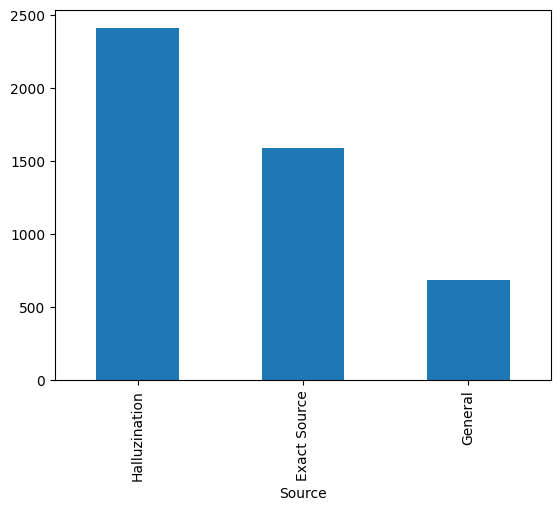

In [3]:
data["Source"].value_counts().plot(kind='bar')

<Axes: xlabel='Final Rating'>

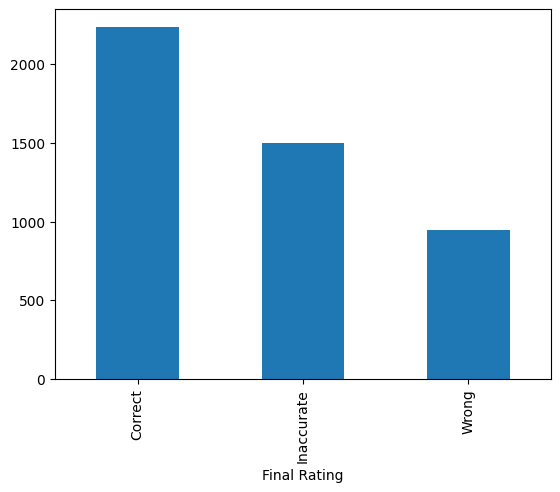

In [4]:
data["Final Rating"] = data["Final Rating"].str.capitalize()
data["Final Rating"].value_counts().plot(kind='bar')

In [5]:
data["Model"].unique()

array(['Gemini-1.5-Pro', 'GPT-4o', 'GPT-4o +RAG', 'GPT-4o mini',
       'GPT-4-Turbo', 'Llama-3.1-nemotron-70b',
       'Llama-3.1-sonar-405b-online', 'LLaMA3-70b-8192', 'Mixtral-8x7b'],
      dtype=object)

In [6]:
model_dict = {"LLaMA3-70b-8192": "LLaMA3-70b", 
              "GPT-4-Turbo": "GPT-4 Turbo",
              "Mixtral": "Mixtral-8x7b",
              "GPT-4o +RAG": "GPT-4o + RAG",
              "GPT-4o mini" : "GPT-4o mini",
              "Llama-3.1-nemotron-70b": "LLaMA3.1-Nemotron-70b",
              "Llama-3.1-sonar-405b-online" : "LLaMA3.1-Sonar-405b + Online"
              }
data["Model"] = data["Model"].replace(model_dict)
              

In [7]:
# Define unified mappings for RAG and Online models
rag_online_mapping = {
    'Exact Source': 'RAG/Online + Existing Sources',
    'General': 'RAG/Online + General Claim',
    'Halluzination': 'RAG/Online + Hallucination'
}

# Update 'Source' column for RAG and Online models
data.loc[data["Model"].str.contains("RAG|Online"), "Source"] = data["Source"].replace(rag_online_mapping)

# Update non-RAG/Online models using a general fallback mapping
general_mapping = {
    'Exact Source': 'Existing Sources',
    'Halluzination': 'Source Hallucination',
    'General': 'General Claim'
}
data["Source"] = data["Source"].replace(general_mapping)


# Analysis of Ratings

## Main

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


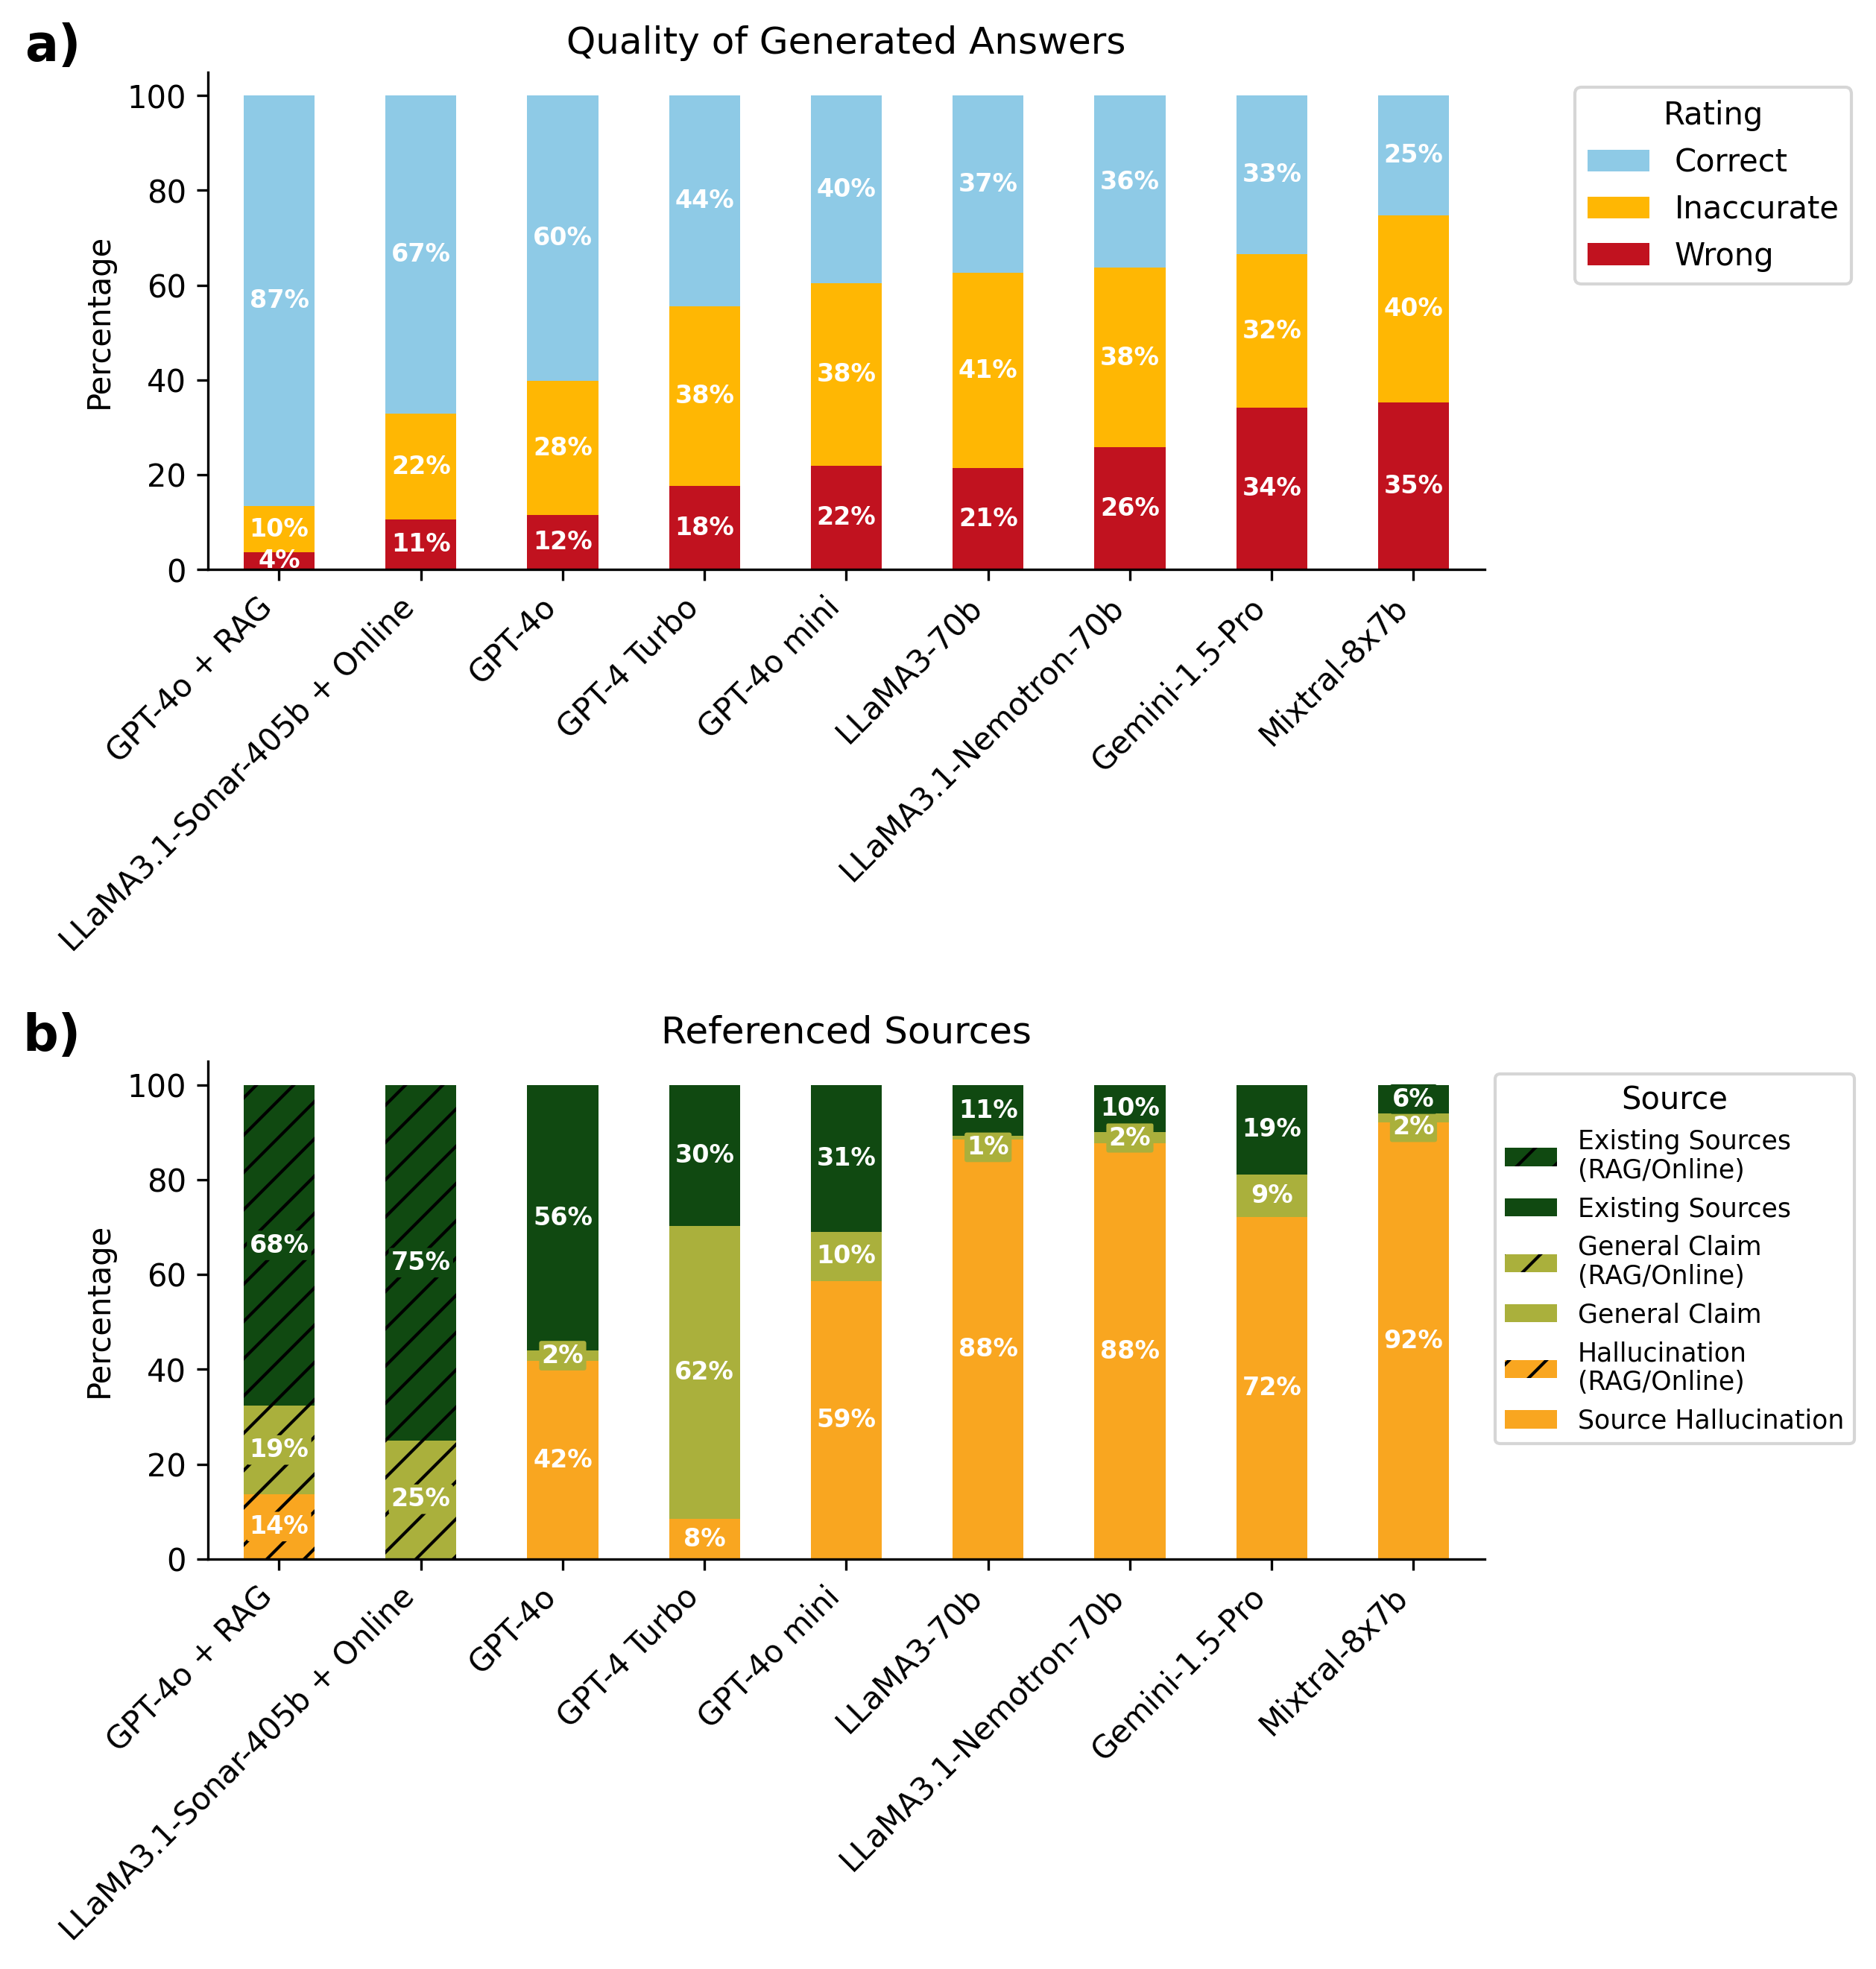

In [8]:
# Define a custom function to format the labels
def custom_label_func(labels):
    return [f'{label:.0f}%' if float(label) > 0 else '' for label in labels]

# Calculate the percentage distributions
rating_counts = data.groupby('Model')['Final Rating'].value_counts(normalize=True).unstack().fillna(0) * 100
source_counts = data.groupby('Model')['Source'].value_counts(normalize=True).unstack().fillna(0) * 100

# Sort models by the percentage of 'Correct' ratings
sorted_models_by_correct = rating_counts.sort_values('Correct', ascending=False).index

# Define colors for the plots
colors_rating = {'Correct': '#8ecae6', 'Inaccurate': '#ffb703', 'Wrong': '#c1121f'}
colors_source = {
    'Existing Sources': '#104911',
    'General Claim': '#aab03c',
    'Source Hallucination': '#f9a620',
    'RAG/Online + Existing Sources': '#104911',
    'RAG/Online + General Claim': '#aab03c',
    'RAG/Online + Hallucination': '#f9a620'
}

# Define hatch styles for the new sources
hatch_styles = {
    'Existing Sources': '',
    'General Claim': '',
    'Source Hallucination': '',
    'RAG/Online + Existing Sources': '//',
    'RAG/Online + General Claim': '//',
    'RAG/Online + Hallucination': '//'
}

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 9), dpi=300)

# Remove top and right spines
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Rating distribution plot
bars = rating_counts.loc[sorted_models_by_correct][['Wrong', 'Inaccurate', 'Correct']].plot(
    kind='bar', stacked=True, color=[colors_rating['Wrong'], colors_rating['Inaccurate'], colors_rating['Correct']], ax=axes[0])

# Add labels to the bars
for bar_container in bars.containers:
    labels = [x.get_height() for x in bar_container]
    bar_labels = custom_label_func(labels)
    for rect, label in zip(bar_container, bar_labels):
        height = rect.get_height()
        if height > 1:
            axes[0].text(rect.get_x() + rect.get_width() / 2, rect.get_y() + height / 2,
                         label, ha='center', va='center', fontsize=8, weight='bold', color='white')
        elif height > 0:
            axes[0].text(rect.get_x() + rect.get_width() / 2, rect.get_y() + height / 2 - 1,
                         '*', ha='center', va='center', fontsize=10, weight='bold', color='white')

axes[0].text(-0.1, 1.1, 'a)', transform=axes[0].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
axes[0].set_title('Quality of Generated Answers')
axes[0].set_ylabel('Percentage')
axes[0].set_xlabel('')
axes[0].legend(title='Rating', labels=['Correct', 'Inaccurate', 'Wrong'], loc='upper right', bbox_to_anchor=(1.25, 1), fontsize='small')
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles=handles[::-1], title='Rating', labels=['Correct', 'Inaccurate', 'Wrong'], loc='upper right', bbox_to_anchor=(1.3, 1))
plt.setp(axes[0].get_xticklabels(), rotation=45, ha="right")

# Source distribution plot
order = [
    'Source Hallucination', 'RAG/Online + Hallucination',
    'General Claim', 'RAG/Online + General Claim',
    'Existing Sources', 'RAG/Online + Existing Sources'
]
bars = source_counts.loc[sorted_models_by_correct][order].plot(
    kind='bar', stacked=True, color=[colors_source[label] for label in order], ax=axes[1])

# Apply hatch styles to new sources
for i, bar_container in enumerate(bars.containers):
    for patch in bar_container:
        label = order[i]
        patch.set_hatch(hatch_styles[label])

# Apply labels to the bars with adjusted background style
for bar_container in bars.containers:
    for patch in bar_container:
        height = patch.get_height()
        if height > 0:
            bbox_props = dict(boxstyle="round,pad=0.1", facecolor=patch.get_facecolor(), edgecolor='none', alpha=1)
            if height > 2:
                axes[1].text(patch.get_x() + patch.get_width() / 2, patch.get_y() + height / 2,
                             f'{height:.0f}%', ha='center', va='center', fontsize=8, weight='bold', color='white', bbox=bbox_props)
            elif height > 0.4:
                axes[1].text(patch.get_x() + patch.get_width() / 2, (patch.get_y() + height / 2)-2,
                    f'{height:.0f}%', ha='center', va='center', fontsize=8, weight='bold', color='white', bbox=bbox_props)

            # elif height > 0:
            #     axes[1].text(patch.get_x() + patch.get_width() / 2, patch.get_y() + height / 2,
            #                  '*', ha='center', va='center', fontsize=8, weight='bold', color='white')

axes[1].text(-0.1, 1.1, 'b)', transform=axes[1].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
axes[1].set_title('Referenced Sources')
axes[1].set_ylabel('Percentage')
axes[1].set_xlabel('')

# Update the legend for the second plot
handles, labels = axes[1].get_legend_handles_labels()

# Rewrite labels to include the desired format with newlines
formatted_labels = [
    label.replace('RAG/Online + Existing Sources', 'Existing Sources\n(RAG/Online)')
         .replace('RAG/Online + General Claim', 'General Claim\n(RAG/Online)')
         .replace('RAG/Online + Hallucination', 'Hallucination\n(RAG/Online)')
    for label in labels
]

# Reverse the order of handles and labels
handles = handles[::-1]
formatted_labels = formatted_labels[::-1]

# Update the legend with reversed handles and labels
axes[1].legend(handles, formatted_labels, title='Source', loc='upper right', bbox_to_anchor=(1.3, 1), fontsize='small')


# Layout adjustment
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save the figures
plt.savefig('Visualizations/Fig_1.png', dpi=300)
plt.savefig('Visualizations/Fig_1.eps', dpi=300)
plt.savefig('Visualizations/Fig_1.svg', dpi=300)

plt.show()


In [9]:
# Give out a table with the absolute as well as percentage of correct, inaccurate and wrong answers for each model
rating_counts = data.groupby('Model')['Final Rating'].value_counts().unstack().fillna(0)
rating_counts['Total'] = rating_counts.sum(axis=1)
#add percentage columns
rating_counts['Correct (%)'] = rating_counts['Correct'] / rating_counts['Total'] * 100
rating_counts['Inaccurate (%)'] = rating_counts['Inaccurate'] / rating_counts['Total'] * 100
rating_counts['Wrong (%)'] = rating_counts['Wrong'] / rating_counts['Total'] * 100
#round to 1 decimal
rating_counts = rating_counts.round(1)
rating_counts

Final Rating,Correct,Inaccurate,Wrong,Total,Correct (%),Inaccurate (%),Wrong (%)
Model,,,,,,,
GPT-4 Turbo,231,197,92,520,44.4,37.9,17.7
GPT-4o,313,147,60,520,60.2,28.3,11.5
GPT-4o + RAG,450,51,19,520,86.5,9.8,3.7
GPT-4o mini,206,200,114,520,39.6,38.5,21.9
Gemini-1.5-Pro,174,168,178,520,33.5,32.3,34.2
LLaMA3-70b,194,215,111,520,37.3,41.3,21.3
LLaMA3.1-Nemotron-70b,189,197,134,520,36.3,37.9,25.8
LLaMA3.1-Sonar-405b + Online,349,116,55,520,67.1,22.3,10.6
Mixtral-8x7b,131,206,183,520,25.2,39.6,35.2


In [10]:
# Calculate source counts and percentages
source_counts = data.groupby('Model')['Source'].value_counts().unstack().fillna(0)
source_counts['Total'] = source_counts.sum(axis=1)

# Add percentage columns for the updated labels
source_counts['Existing Sources (%)'] = source_counts['Existing Sources'] / source_counts['Total'] * 100
source_counts['General Claim (%)'] = source_counts['General Claim'] / source_counts['Total'] * 100
source_counts['Source Hallucination (%)'] = source_counts['Source Hallucination'] / source_counts['Total'] * 100
source_counts['Existing Sources (RAG/Online) (%)'] = source_counts['RAG/Online + Existing Sources'] / source_counts['Total'] * 100
source_counts['General Claim (RAG/Online) (%)'] = source_counts['RAG/Online + General Claim'] / source_counts['Total'] * 100
source_counts['Hallucination (RAG/Online) (%)'] = source_counts['RAG/Online + Hallucination'] / source_counts['Total'] * 100

# Round percentages to 1 decimal place
source_counts = source_counts.round(1)

source_counts


Source,Existing Sources,General Claim,RAG/Online + Existing Sources,RAG/Online + General Claim,RAG/Online + Hallucination,Source Hallucination,Total,Existing Sources (%),General Claim (%),Source Hallucination (%),Existing Sources (RAG/Online) (%),General Claim (RAG/Online) (%),Hallucination (RAG/Online) (%)
Model,,,,,,,,,,,,,
GPT-4 Turbo,155.0,321.0,0.0,0.0,0.0,44.0,520.0,29.8,61.7,8.5,0.0,0.0,0.0
GPT-4o,291.0,12.0,0.0,0.0,0.0,217.0,520.0,56.0,2.3,41.7,0.0,0.0,0.0
GPT-4o + RAG,0.0,0.0,352.0,97.0,71.0,0.0,520.0,0.0,0.0,0.0,67.7,18.7,13.7
GPT-4o mini,161.0,54.0,0.0,0.0,0.0,305.0,520.0,31.0,10.4,58.7,0.0,0.0,0.0
Gemini-1.5-Pro,98.0,47.0,0.0,0.0,0.0,375.0,520.0,18.8,9.0,72.1,0.0,0.0,0.0
LLaMA3-70b,56.0,4.0,0.0,0.0,0.0,460.0,520.0,10.8,0.8,88.5,0.0,0.0,0.0
LLaMA3.1-Nemotron-70b,52.0,12.0,0.0,0.0,0.0,456.0,520.0,10.0,2.3,87.7,0.0,0.0,0.0
LLaMA3.1-Sonar-405b + Online,0.0,0.0,390.0,129.0,1.0,0.0,520.0,0.0,0.0,0.0,75.0,24.8,0.2
Mixtral-8x7b,31.0,10.0,0.0,0.0,0.0,479.0,520.0,6.0,1.9,92.1,0.0,0.0,0.0


## Sub Analysis

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


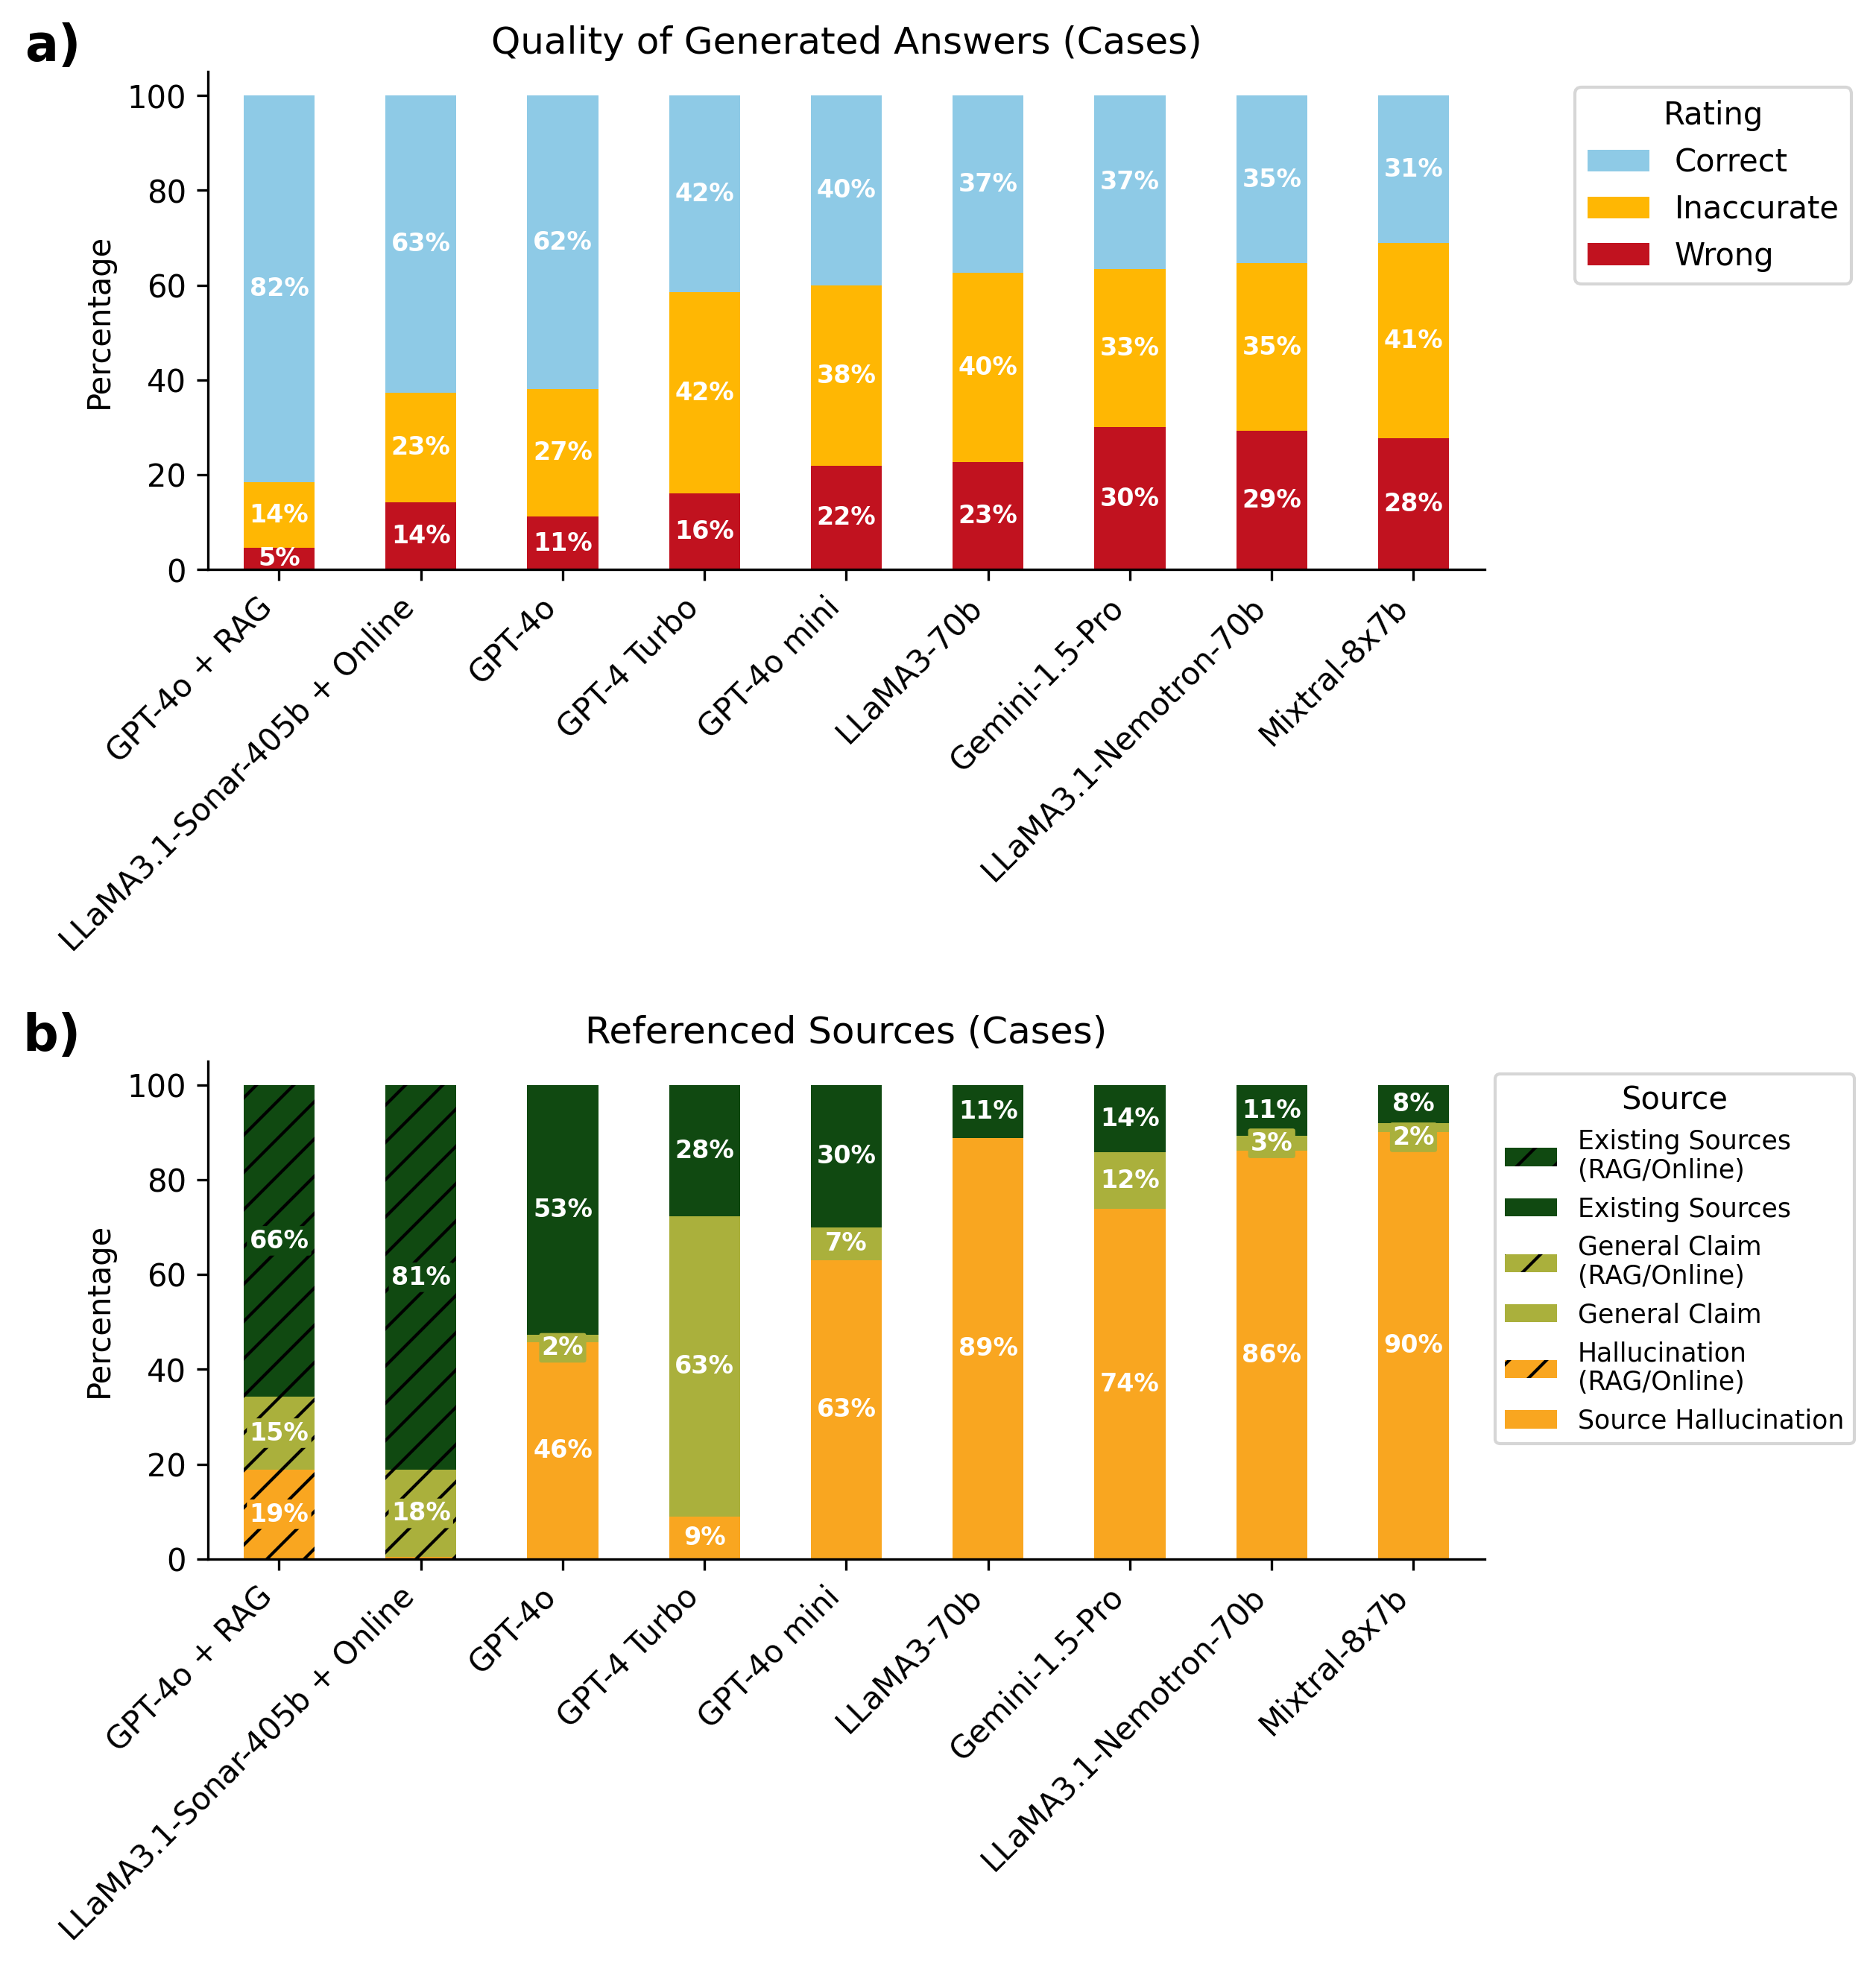

In [11]:
case_data = data[data["Type"] == "Case"]

# Define a custom function to format the labels
def custom_label_func(labels):
    return [f'{label:.0f}%' if float(label) > 0 else '' for label in labels]

# Calculate the percentage distributions
rating_counts = case_data.groupby('Model')['Final Rating'].value_counts(normalize=True).unstack().fillna(0) * 100
source_counts = case_data.groupby('Model')['Source'].value_counts(normalize=True).unstack().fillna(0) * 100

# Sort models by the percentage of 'Correct' ratings
sorted_models_by_correct = rating_counts.sort_values('Correct', ascending=False).index

# Define colors for the plots
colors_rating = {'Correct': '#8ecae6', 'Inaccurate': '#ffb703', 'Wrong': '#c1121f'}
colors_source = {
    'Existing Sources': '#104911',
    'General Claim': '#aab03c',
    'Source Hallucination': '#f9a620',
    'RAG/Online + Existing Sources': '#104911',
    'RAG/Online + General Claim': '#aab03c',
    'RAG/Online + Hallucination': '#f9a620'
}

# Define hatch styles for the new sources
hatch_styles = {
    'Existing Sources': '',
    'General Claim': '',
    'Source Hallucination': '',
    'RAG/Online + Existing Sources': '//',
    'RAG/Online + General Claim': '//',
    'RAG/Online + Hallucination': '//'
}

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 9), dpi=300)

# Remove top and right spines
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Rating distribution plot
bars = rating_counts.loc[sorted_models_by_correct][['Wrong', 'Inaccurate', 'Correct']].plot(
    kind='bar', stacked=True, color=[colors_rating['Wrong'], colors_rating['Inaccurate'], colors_rating['Correct']], ax=axes[0])

# Add labels to the bars
for bar_container in bars.containers:
    labels = [x.get_height() for x in bar_container]
    bar_labels = custom_label_func(labels)
    for rect, label in zip(bar_container, bar_labels):
        height = rect.get_height()
        if height > 1:
            axes[0].text(rect.get_x() + rect.get_width() / 2, rect.get_y() + height / 2,
                         label, ha='center', va='center', fontsize=8, weight='bold', color='white')
        elif height > 0:
            axes[0].text(rect.get_x() + rect.get_width() / 2, rect.get_y() + height / 2 - 1,
                         '*', ha='center', va='center', fontsize=10, weight='bold', color='white')

axes[0].text(-0.1, 1.1, 'a)', transform=axes[0].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
axes[0].set_title('Quality of Generated Answers (Cases)')
axes[0].set_ylabel('Percentage')
axes[0].set_xlabel('')
axes[0].legend(title='Rating', labels=['Correct', 'Inaccurate', 'Wrong'], loc='upper right', bbox_to_anchor=(1.25, 1), fontsize='small')
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles=handles[::-1], title='Rating', labels=['Correct', 'Inaccurate', 'Wrong'], loc='upper right', bbox_to_anchor=(1.3, 1))
plt.setp(axes[0].get_xticklabels(), rotation=45, ha="right")

# Source distribution plot
order = [
    'Source Hallucination', 'RAG/Online + Hallucination',
    'General Claim', 'RAG/Online + General Claim',
    'Existing Sources', 'RAG/Online + Existing Sources'
]
bars = source_counts.loc[sorted_models_by_correct][order].plot(
    kind='bar', stacked=True, color=[colors_source[label] for label in order], ax=axes[1])

# Apply hatch styles to new sources
for i, bar_container in enumerate(bars.containers):
    for patch in bar_container:
        label = order[i]
        patch.set_hatch(hatch_styles[label])

# Apply labels to the bars with adjusted background style
for bar_container in bars.containers:
    for patch in bar_container:
        height = patch.get_height()
        if height > 0:
            bbox_props = dict(boxstyle="round,pad=0.1", facecolor=patch.get_facecolor(), edgecolor='none', alpha=1)
            if height > 2:
                axes[1].text(patch.get_x() + patch.get_width() / 2, patch.get_y() + height / 2,
                             f'{height:.0f}%', ha='center', va='center', fontsize=8, weight='bold', color='white', bbox=bbox_props)
            elif height > 0.4:
                axes[1].text(patch.get_x() + patch.get_width() / 2, (patch.get_y() + height / 2)-2,
                    f'{height:.0f}%', ha='center', va='center', fontsize=8, weight='bold', color='white', bbox=bbox_props)

            # elif height > 0:
            #     axes[1].text(patch.get_x() + patch.get_width() / 2, patch.get_y() + height / 2,
            #                  '*', ha='center', va='center', fontsize=8, weight='bold', color='white')

axes[1].text(-0.1, 1.1, 'b)', transform=axes[1].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
axes[1].set_title('Referenced Sources (Cases)')
axes[1].set_ylabel('Percentage')
axes[1].set_xlabel('')

# Update the legend for the second plot
handles, labels = axes[1].get_legend_handles_labels()

# Rewrite labels to include the desired format with newlines
formatted_labels = [
    label.replace('RAG/Online + Existing Sources', 'Existing Sources\n(RAG/Online)')
         .replace('RAG/Online + General Claim', 'General Claim\n(RAG/Online)')
         .replace('RAG/Online + Hallucination', 'Hallucination\n(RAG/Online)')
    for label in labels
]

# Reverse the order of handles and labels
handles = handles[::-1]
formatted_labels = formatted_labels[::-1]

# Update the legend with reversed handles and labels
axes[1].legend(handles, formatted_labels, title='Source', loc='upper right', bbox_to_anchor=(1.3, 1), fontsize='small')


# Layout adjustment
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save the figures
plt.savefig('Visualizations/Fig_1_Cases.png', dpi=300)
plt.savefig('Visualizations/Fig_1_Cases.eps', dpi=300)
plt.savefig('Visualizations/Fig_1_Cases.svg', dpi=300)

plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


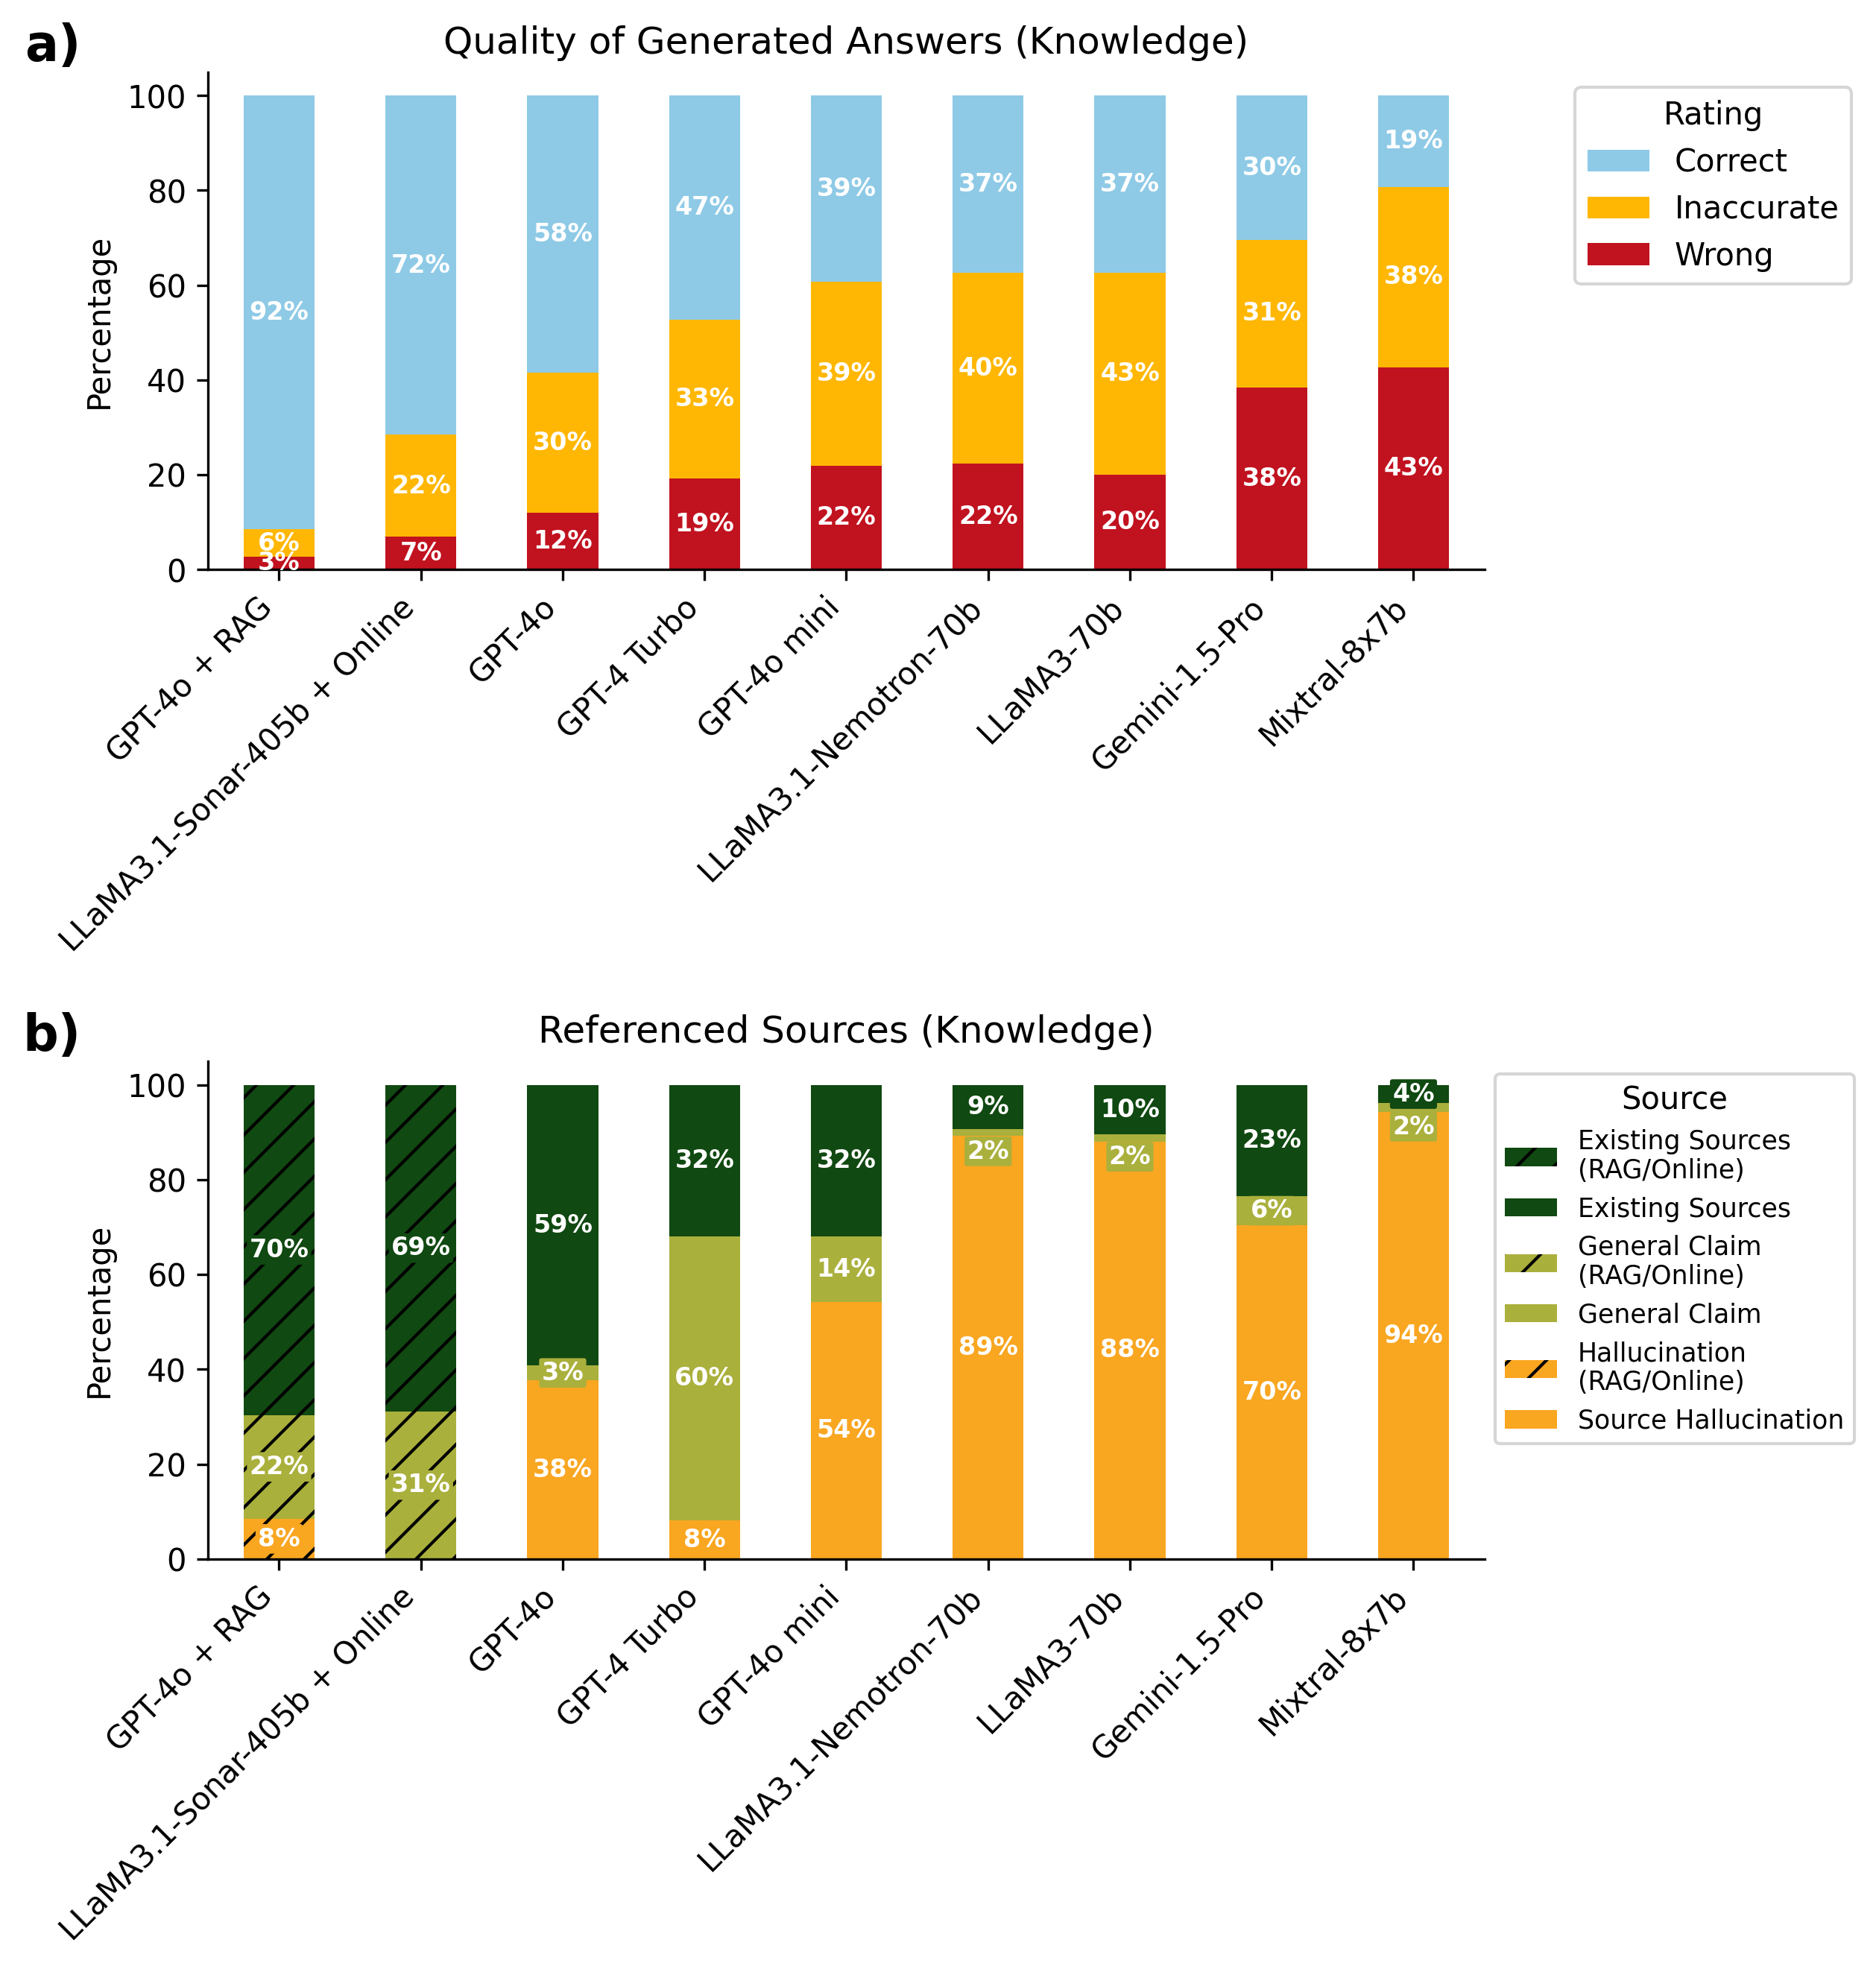

In [12]:
knowledge_data = data[data["Type"] == "Knowledge"]

# Define a custom function to format the labels
def custom_label_func(labels):
    return [f'{label:.0f}%' if float(label) > 0 else '' for label in labels]

# Calculate the percentage distributions
rating_counts = knowledge_data.groupby('Model')['Final Rating'].value_counts(normalize=True).unstack().fillna(0) * 100
source_counts = knowledge_data.groupby('Model')['Source'].value_counts(normalize=True).unstack().fillna(0) * 100

# Sort models by the percentage of 'Correct' ratings
sorted_models_by_correct = rating_counts.sort_values('Correct', ascending=False).index

# Define colors for the plots
colors_rating = {'Correct': '#8ecae6', 'Inaccurate': '#ffb703', 'Wrong': '#c1121f'}
colors_source = {
    'Existing Sources': '#104911',
    'General Claim': '#aab03c',
    'Source Hallucination': '#f9a620',
    'RAG/Online + Existing Sources': '#104911',
    'RAG/Online + General Claim': '#aab03c',
    'RAG/Online + Hallucination': '#f9a620'
}

# Define hatch styles for the new sources
hatch_styles = {
    'Existing Sources': '',
    'General Claim': '',
    'Source Hallucination': '',
    'RAG/Online + Existing Sources': '//',
    'RAG/Online + General Claim': '//',
    'RAG/Online + Hallucination': '//'
}

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 9), dpi=300)

# Remove top and right spines
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Rating distribution plot
bars = rating_counts.loc[sorted_models_by_correct][['Wrong', 'Inaccurate', 'Correct']].plot(
    kind='bar', stacked=True, color=[colors_rating['Wrong'], colors_rating['Inaccurate'], colors_rating['Correct']], ax=axes[0])

# Add labels to the bars
for bar_container in bars.containers:
    labels = [x.get_height() for x in bar_container]
    bar_labels = custom_label_func(labels)
    for rect, label in zip(bar_container, bar_labels):
        height = rect.get_height()
        if height > 1:
            axes[0].text(rect.get_x() + rect.get_width() / 2, rect.get_y() + height / 2,
                         label, ha='center', va='center', fontsize=8, weight='bold', color='white')
        elif height > 0:
            axes[0].text(rect.get_x() + rect.get_width() / 2, rect.get_y() + height / 2 - 1,
                         '*', ha='center', va='center', fontsize=10, weight='bold', color='white')

axes[0].text(-0.1, 1.1, 'a)', transform=axes[0].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
axes[0].set_title('Quality of Generated Answers (Knowledge)')
axes[0].set_ylabel('Percentage')
axes[0].set_xlabel('')
axes[0].legend(title='Rating', labels=['Correct', 'Inaccurate', 'Wrong'], loc='upper right', bbox_to_anchor=(1.25, 1), fontsize='small')
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles=handles[::-1], title='Rating', labels=['Correct', 'Inaccurate', 'Wrong'], loc='upper right', bbox_to_anchor=(1.3, 1))
plt.setp(axes[0].get_xticklabels(), rotation=45, ha="right")

# Source distribution plot
order = [
    'Source Hallucination', 'RAG/Online + Hallucination',
    'General Claim', 'RAG/Online + General Claim',
    'Existing Sources', 'RAG/Online + Existing Sources'
]
bars = source_counts.loc[sorted_models_by_correct][order].plot(
    kind='bar', stacked=True, color=[colors_source[label] for label in order], ax=axes[1])

# Apply hatch styles to new sources
for i, bar_container in enumerate(bars.containers):
    for patch in bar_container:
        label = order[i]
        patch.set_hatch(hatch_styles[label])

# Apply labels to the bars with adjusted background style
for bar_container in bars.containers:
    for patch in bar_container:
        height = patch.get_height()
        if height > 0:
            bbox_props = dict(boxstyle="round,pad=0.1", facecolor=patch.get_facecolor(), edgecolor='none', alpha=1)
            if height > 2:
                axes[1].text(patch.get_x() + patch.get_width() / 2, patch.get_y() + height / 2,
                             f'{height:.0f}%', ha='center', va='center', fontsize=8, weight='bold', color='white', bbox=bbox_props)
            elif height > 0.4:
                axes[1].text(patch.get_x() + patch.get_width() / 2, (patch.get_y() + height / 2)-4,
                    f'{height:.0f}%', ha='center', va='center', fontsize=8, weight='bold', color='white', bbox=bbox_props)

            # elif height > 0:
            #     axes[1].text(patch.get_x() + patch.get_width() / 2, patch.get_y() + height / 2,
            #                  '*', ha='center', va='center', fontsize=8, weight='bold', color='white')

axes[1].text(-0.1, 1.1, 'b)', transform=axes[1].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
axes[1].set_title('Referenced Sources (Knowledge)')
axes[1].set_ylabel('Percentage')
axes[1].set_xlabel('')

# Update the legend for the second plot
handles, labels = axes[1].get_legend_handles_labels()

# Rewrite labels to include the desired format with newlines
formatted_labels = [
    label.replace('RAG/Online + Existing Sources', 'Existing Sources\n(RAG/Online)')
         .replace('RAG/Online + General Claim', 'General Claim\n(RAG/Online)')
         .replace('RAG/Online + Hallucination', 'Hallucination\n(RAG/Online)')
    for label in labels
]

# Reverse the order of handles and labels
handles = handles[::-1]
formatted_labels = formatted_labels[::-1]

# Update the legend with reversed handles and labels
axes[1].legend(handles, formatted_labels, title='Source', loc='upper right', bbox_to_anchor=(1.3, 1), fontsize='small')


# Layout adjustment
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save the figures
plt.savefig('Visualizations/Fig_1_Knowledge.png', dpi=300)
plt.savefig('Visualizations/Fig_1_Knowledge.eps', dpi=300)
plt.savefig('Visualizations/Fig_1_Knowledge.svg', dpi=300)

plt.show()


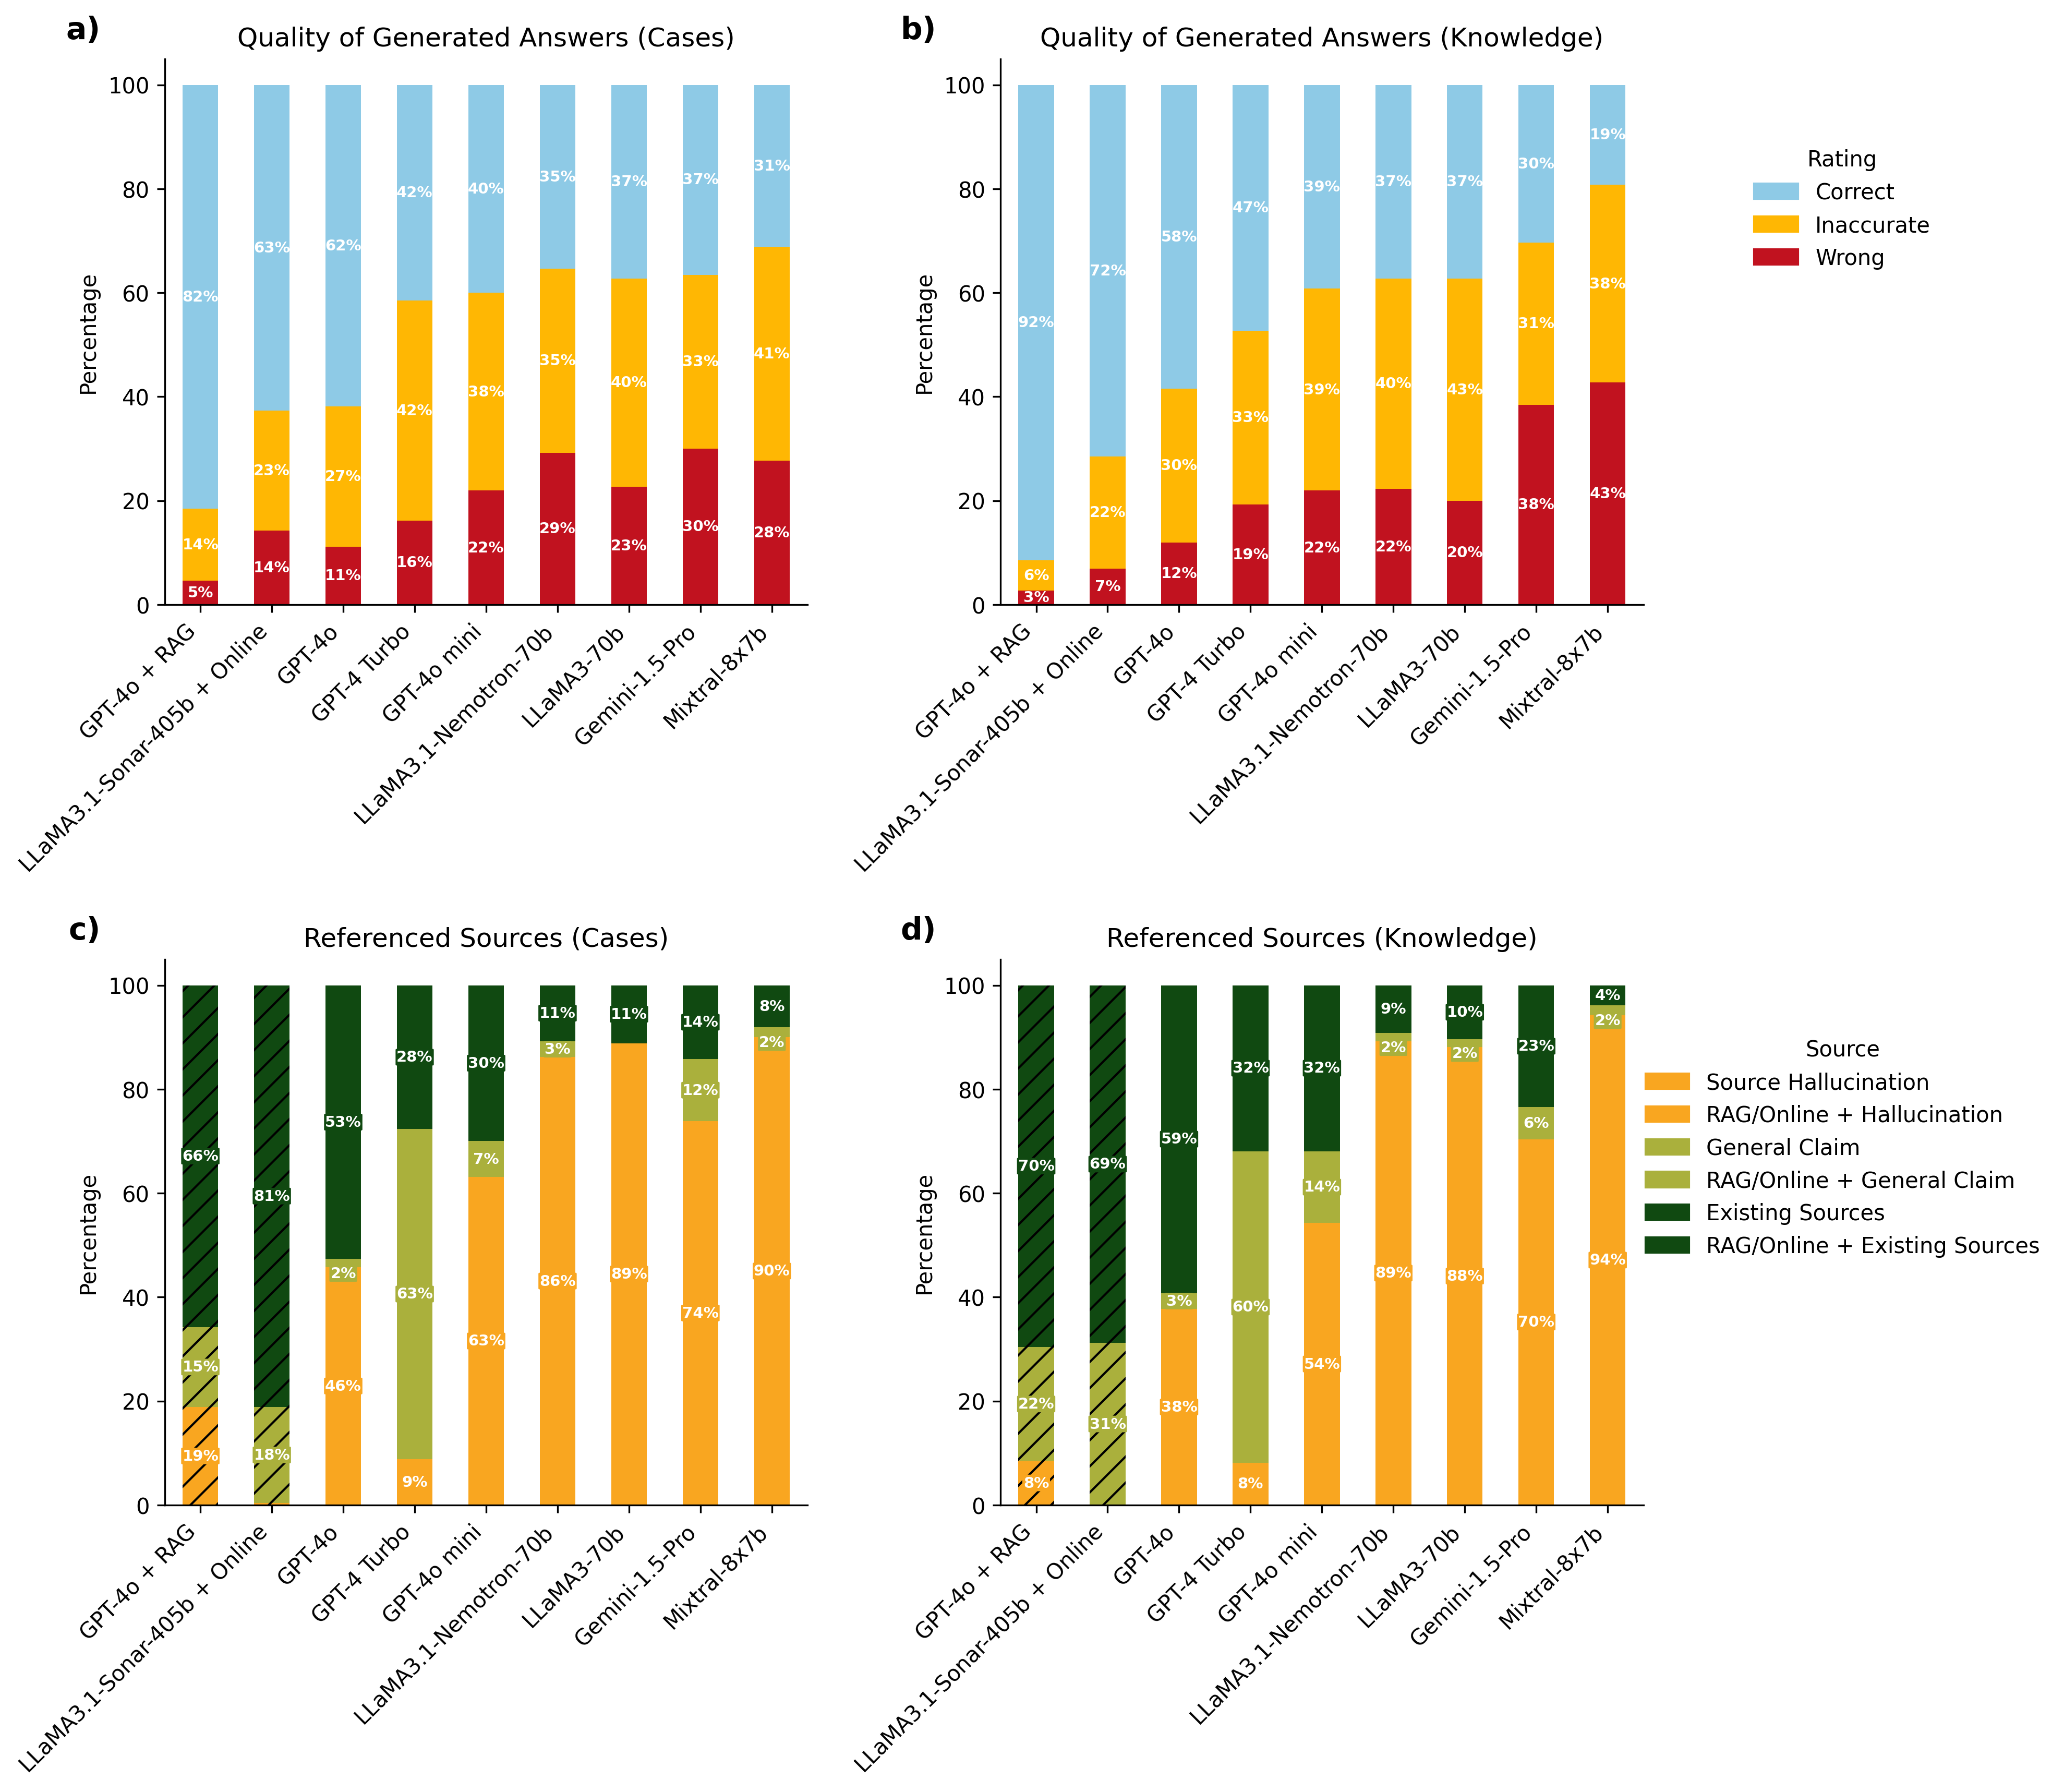

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

case_data = data[data["Type"] == "Case"]
knowledge_data = data[data["Type"] == "Knowledge"]

def custom_label_func(labels):
    return [f'{label:.0f}%' if float(label) > 0 else '' for label in labels]

colors_rating = {
    'Correct': '#8ecae6',
    'Inaccurate': '#ffb703',
    'Wrong': '#c1121f'
}

colors_source = {
    'Existing Sources': '#104911',
    'General Claim': '#aab03c',
    'Source Hallucination': '#f9a620',
    'RAG/Online + Existing Sources': '#104911',
    'RAG/Online + General Claim': '#aab03c',
    'RAG/Online + Hallucination': '#f9a620'
}

hatch_styles = {
    'Existing Sources': '',
    'General Claim': '',
    'Source Hallucination': '',
    'RAG/Online + Existing Sources': '//',
    'RAG/Online + General Claim': '//',
    'RAG/Online + Hallucination': '//'
}

# Calculate the percentage distributions
rating_counts_case = case_data.groupby('Model')['Final Rating'].value_counts(normalize=True).unstack().fillna(0) * 100
source_counts_case = case_data.groupby('Model')['Source'].value_counts(normalize=True).unstack().fillna(0) * 100
rating_counts_know = knowledge_data.groupby('Model')['Final Rating'].value_counts(normalize=True).unstack().fillna(0) * 100
source_counts_know = knowledge_data.groupby('Model')['Source'].value_counts(normalize=True).unstack().fillna(0) * 100

# Use the sorted order based on "Correct" ratings for knowledge data
sorted_models_by_correct = rating_counts_know.sort_values('Correct', ascending=False).index

# Reindex all dataframes to the common order
rating_counts_case = rating_counts_case.reindex(index=sorted_models_by_correct)
rating_counts_know = rating_counts_know.reindex(index=sorted_models_by_correct)
source_counts_case = source_counts_case.reindex(index=sorted_models_by_correct)
source_counts_know = source_counts_know.reindex(index=sorted_models_by_correct)

# Define the stacking order for sources
source_order = [
    'Source Hallucination',
    'RAG/Online + Hallucination',
    'General Claim',
    'RAG/Online + General Claim',
    'Existing Sources',
    'RAG/Online + Existing Sources'
]

# Create the 2x2 figure
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12), dpi=300)
fig.subplots_adjust(hspace=0.65, wspace=0.3)

# Plot for "Quality of Generated Answers (Cases)"
ax_a = axes[0, 0]
bars_a = rating_counts_case[['Wrong', 'Inaccurate', 'Correct']].plot(
    kind='bar', stacked=True,
    color=[colors_rating['Wrong'], colors_rating['Inaccurate'], colors_rating['Correct']],
    ax=ax_a
)
for bar_container in bars_a.containers:
    labels = [x.get_height() for x in bar_container]
    bar_labels = custom_label_func(labels)
    for rect, label in zip(bar_container, bar_labels):
        height = rect.get_height()
        if height > 1:
            ax_a.text(rect.get_x() + rect.get_width() / 2, rect.get_y() + height / 2,
                      label, ha='center', va='center', fontsize=7, weight='bold', color='white')
        elif height > 0:
            ax_a.text(rect.get_x() + rect.get_width() / 2, rect.get_y() + height / 2 - 1,
                      '*', ha='center', va='center', fontsize=7, weight='bold', color='white')

ax_a.text(-0.1, 1.08, 'a)', transform=ax_a.transAxes,
          fontsize=14, fontweight='bold', va='top', ha='right')
ax_a.set_title('Quality of Generated Answers (Cases)')
ax_a.set_ylabel('Percentage')
ax_a.set_xlabel('')
ax_a.legend([], frameon=False)
plt.setp(ax_a.get_xticklabels(), rotation=45, ha="right")

# Plot for "Quality of Generated Answers (Knowledge)"
ax_b = axes[0, 1]
bars_b = rating_counts_know[['Wrong', 'Inaccurate', 'Correct']].plot(
    kind='bar', stacked=True,
    color=[colors_rating['Wrong'], colors_rating['Inaccurate'], colors_rating['Correct']],
    ax=ax_b
)
for bar_container in bars_b.containers:
    labels = [x.get_height() for x in bar_container]
    bar_labels = custom_label_func(labels)
    for rect, label in zip(bar_container, bar_labels):
        height = rect.get_height()
        if height > 1:
            ax_b.text(rect.get_x() + rect.get_width() / 2, rect.get_y() + height / 2,
                      label, ha='center', va='center', fontsize=7, weight='bold', color='white')
        elif height > 0:
            ax_b.text(rect.get_x() + rect.get_width() / 2, rect.get_y() + height / 2 - 1,
                      '*', ha='center', va='center', fontsize=7, weight='bold', color='white')

ax_b.text(-0.1, 1.08, 'b)', transform=ax_b.transAxes,
          fontsize=14, fontweight='bold', va='top', ha='right')
ax_b.set_title('Quality of Generated Answers (Knowledge)')
ax_b.set_ylabel('Percentage')
ax_b.set_xlabel('')
ax_b.legend([], frameon=False)
plt.setp(ax_b.get_xticklabels(), rotation=45, ha="right")

# Plot for "Referenced Sources (Cases)"
ax_c = axes[1, 0]
bars_c = source_counts_case[source_order].plot(
    kind='bar', stacked=True,
    color=[colors_source[x] for x in source_order],
    ax=ax_c
)
for i, bar_container in enumerate(bars_c.containers):
    label = source_order[i]
    for patch in bar_container:
        patch.set_hatch(hatch_styles[label])

# Add numeric labels to "Referenced Sources (Cases)"
for bar_container in bars_c.containers:
    for patch in bar_container:
        height = patch.get_height()
        if height > 0:
            bbox_props = dict(boxstyle="round,pad=0.065", facecolor=patch.get_facecolor(),
                              edgecolor='none', alpha=1)
            if height > 2:
                ax_c.text(patch.get_x() + patch.get_width() / 2, patch.get_y() + height / 2,
                          f'{height:.0f}%', ha='center', va='center', fontsize=7, weight='bold',
                          color='white', bbox=bbox_props)
            elif height > 0.4:
                ax_c.text(patch.get_x() + patch.get_width() / 2,
                          (patch.get_y() + height / 2) - 2,
                          f'{height:.0f}%', ha='center', va='center', fontsize=7,
                          weight='bold', color='white', bbox=bbox_props)

ax_c.text(-0.1, 1.08, 'c)', transform=ax_c.transAxes,
          fontsize=14, fontweight='bold', va='top', ha='right')
ax_c.set_title('Referenced Sources (Cases)')
ax_c.set_ylabel('Percentage')
ax_c.set_xlabel('')
ax_c.legend([], frameon=False)
plt.setp(ax_c.get_xticklabels(), rotation=45, ha="right")

# Plot for "Referenced Sources (Knowledge)"
ax_d = axes[1, 1]
bars_d = source_counts_know[source_order].plot(
    kind='bar', stacked=True,
    color=[colors_source[x] for x in source_order],
    ax=ax_d
)
for i, bar_container in enumerate(bars_d.containers):
    label = source_order[i]
    for patch in bar_container:
        patch.set_hatch(hatch_styles[label])

# Add numeric labels to "Referenced Sources (Knowledge)"
for bar_container in bars_d.containers:
    for patch in bar_container:
        height = patch.get_height()
        if height > 0:
            bbox_props = dict(boxstyle="round,pad=0.065", facecolor=patch.get_facecolor(),
                              edgecolor='none', alpha=1)
            if height > 2:
                ax_d.text(patch.get_x() + patch.get_width() / 2, patch.get_y() + height / 2,
                          f'{height:.0f}%', ha='center', va='center', fontsize=7, weight='bold',
                          color='white', bbox=bbox_props)
            elif height > 0.4:
                ax_d.text(patch.get_x() + patch.get_width() / 2,
                          (patch.get_y() + height / 2) - 2,
                          f'{height:.0f}%', ha='center', va='center', fontsize=7,
                          weight='bold', color='white', bbox=bbox_props)

ax_d.text(-0.1, 1.08, 'd)', transform=ax_d.transAxes,
          fontsize=14, fontweight='bold', va='top', ha='right')
ax_d.set_title('Referenced Sources (Knowledge)')
ax_d.set_ylabel('Percentage')
ax_d.set_xlabel('')
ax_d.legend([], frameon=False)
plt.setp(ax_d.get_xticklabels(), rotation=45, ha="right")

# Remove spines
for row in axes:
    for ax in row:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

# Create combined legends
legend_elements_rating = [
    plt.Rectangle((0, 0), 1, 1, color=colors_rating[label], label=label)
    for label in ['Correct', 'Inaccurate', 'Wrong']
]

legend_elements_source = [
    plt.Rectangle((0, 0), 1, 1, color=colors_source[label], hatch=hatch_styles[label], label=label)
    for label in source_order
]

ax_a.grid(False)
ax_b.grid(False)
ax_c.grid(False)
ax_d.grid(False)

fig.legend(handles=legend_elements_rating, title='Rating', loc='center right', bbox_to_anchor=(0.94, 0.8), frameon=False)
fig.legend(handles=legend_elements_source, title='Source', loc='center right', bbox_to_anchor=(0.99, 0.3), frameon=False)

# Save and display the figure
plt.subplots_adjust(right=0.8)
plt.savefig('Visualizations/Fig_Combined_SpinesRemoved.png', dpi=300, bbox_inches='tight')
plt.savefig('Visualizations/Fig_Combined_SpinesRemoved.eps', dpi=300, bbox_inches='tight')
plt.savefig('Visualizations/Fig_Combined_SpinesRemoved.svg', dpi=300, bbox_inches='tight')
plt.show()


# Are these differences significant?


In [14]:
import pandas as pd
import numpy as np
from scipy.stats import friedmanchisquare, wilcoxon
import itertools
from statsmodels.stats.multitest import multipletests
import docx

In [15]:
def format_p_value(p):
    if p < 0.001:
        return "P<.001"
    elif p < 0.01:
        return f"P={p:.3f}"
    elif p >= 0.99:
        return "P>.99"
    else:
        return f"P={p:.2f}"


# Define explicit encoding for the rating
rating_mapping = {'Correct': 2, 'Inaccurate': 1, 'Wrong': 0}
data['rating_encoded'] = data['Final Rating'].map(rating_mapping)

# Aggregate duplicates using `batch`, `Model`, and `Question Number` as unique identifiers
cleaned_data = data.groupby(['batch', 'Model', 'Question Number'], as_index=False)['rating_encoded'].median()

# Further aggregate to ensure uniqueness in `Question Number` and `Model`
# Using pandas.Series.mode
final_cleaned_data = cleaned_data.groupby(['Question Number', 'Model'], as_index=False)['rating_encoded'].agg(lambda x: x.mode().iloc[0])


# Pivot the data after resolving all duplicates
model_data = final_cleaned_data.pivot(index='Question Number', columns='Model', values='rating_encoded')

# Count the number of "Correct" ratings for each model
correct_counts = final_cleaned_data[final_cleaned_data['rating_encoded'] == 2].groupby('Model')['rating_encoded'].count()

# Sort the models by the count of "Correct" ratings in descending order
sorted_models = correct_counts.sort_values(ascending=False).index.tolist()

# Reorder the DataFrame columns based on the sorted models
model_data = model_data[sorted_models]

# Explode the data correctly for each column
exploded_data = pd.DataFrame({
    col: model_data[col].explode() for col in model_data.columns
})


# Perform the Friedman Test
friedman_stat, friedman_p = friedmanchisquare(*[exploded_data[col].dropna() for col in exploded_data.columns])

# Generate all pairwise combinations of models for post-hoc analysis
model_pairs = list(itertools.combinations(exploded_data.columns, 2))
p_values = []
indices = []

for pair in model_pairs:
    # Drop NaN values for the Wilcoxon test
    ratings1 = exploded_data[pair[0]].dropna()
    ratings2 = exploded_data[pair[1]].dropna()
    try:
        stat, p_value = wilcoxon(ratings1, ratings2)
    except ValueError:
        p_value = np.nan  # Handle cases with insufficient data for the Wilcoxon test
    indices.append(pair)
    p_values.append(p_value)

# Adjust for multiple comparisons using Bonferroni correction
reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='bonferroni')

# Create a DataFrame to hold the post-hoc results with separated model pair columns
results_df = pd.DataFrame({
    'Model 1': [pair[0] for pair in indices],
    'Model 2': [pair[1] for pair in indices],
    'P-Value Corrected': [format_p_value(p) if not pd.isna(p) else "N/A" for p in pvals_corrected],
    'Significantly Different': ['Yes' if flag else 'No' for flag in reject]
})



In [16]:
print(friedman_stat, friedman_p)
results_df

228.74684500053968 5.451527958203452e-45


,Model 1,Model 2,P-Value Corrected,Significantly Different
0,GPT-4o + RAG,LLaMA3.1-Sonar-405b + Online,P=0.005,Yes
1,GPT-4o + RAG,GPT-4o,P<.001,Yes
2,GPT-4o + RAG,GPT-4 Turbo,P<.001,Yes
3,GPT-4o + RAG,GPT-4o mini,P<.001,Yes
4,GPT-4o + RAG,LLaMA3.1-Nemotron-70b,P<.001,Yes
5,GPT-4o + RAG,LLaMA3-70b,P<.001,Yes
6,GPT-4o + RAG,Gemini-1.5-Pro,P<.001,Yes
7,GPT-4o + RAG,Mixtral-8x7b,P<.001,Yes
8,LLaMA3.1-Sonar-405b + Online,GPT-4o,P>.99,No
9,LLaMA3.1-Sonar-405b + Online,GPT-4 Turbo,P=0.008,Yes


In [17]:
# Save the results to a Word document
doc = docx.Document()
doc.add_heading('Post-Hoc Comparison Results', level=1)

# Add table
table = doc.add_table(rows=1, cols=4)
table.style = 'Table Grid'
hdr_cells = table.rows[0].cells
hdr_cells[0].text = 'Model 1'
hdr_cells[1].text = 'Model 2'
hdr_cells[2].text = 'P-Value Corrected'
hdr_cells[3].text = 'Significantly Different'

for index, row in results_df.iterrows():
    row_cells = table.add_row().cells
    row_cells[0].text = row['Model 1']
    row_cells[1].text = row['Model 2']
    row_cells[2].text = row['P-Value Corrected']
    row_cells[3].text = row['Significantly Different']

# Specify the output path for the Word document
output_path_corrected = 'Results/datatable.docx'
doc.save(output_path_corrected)
output_path_corrected

'Results/datatable.docx'

C:\Users\larsm\AppData\Local\Temp\ipykernel_5576\4039532895.py:33: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_matrix = p_matrix.copy().applymap(lambda x: format_p_value(x))


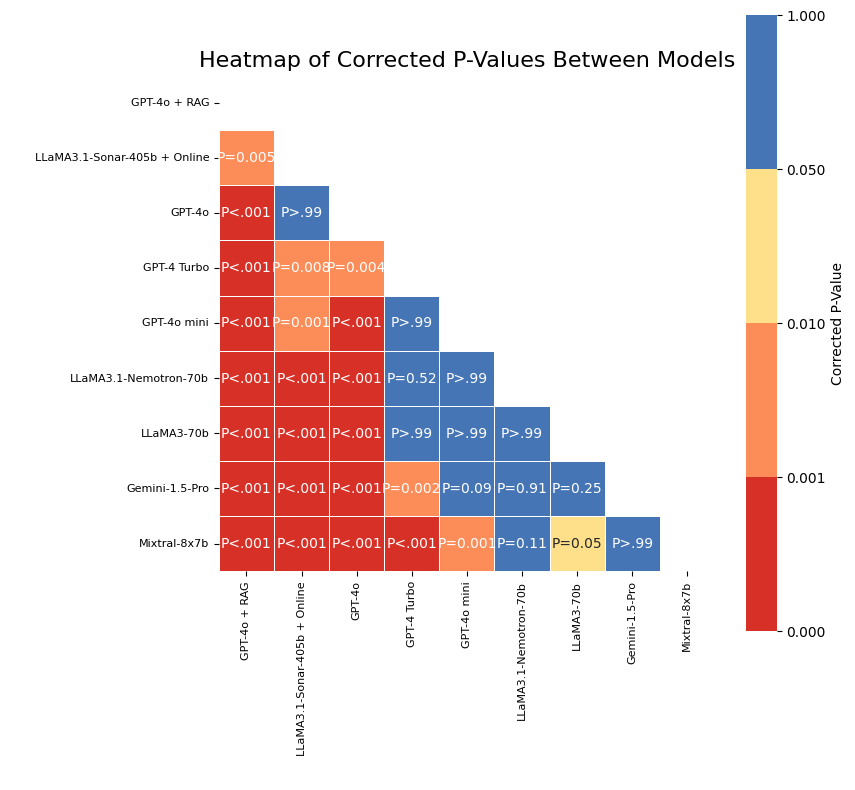

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

# Define the custom formatting function
def format_p_value(p):
    if pd.isna(p):  # Handle NaN values
        return ""
    elif p < 0.001:
        return "P<.001"
    elif p < 0.01:
        return f"P={p:.3f}"
    elif p >= 0.99:
        return "P>.99"
    else:
        return f"P={p:.2f}"

# Create a list of all models (assuming exploded_data is already defined)
models = exploded_data.columns.tolist()

# Initialize an empty matrix for p-values
p_matrix = pd.DataFrame(index=models, columns=models, dtype=float)

# Populate the matrix with p-values
for (model1, model2), p_value in zip(indices, pvals_corrected):
    p_matrix.loc[model1, model2] = p_value
    p_matrix.loc[model2, model1] = p_value  # Ensure symmetry

# Fill diagonal with NaN (no self-comparisons)
np.fill_diagonal(p_matrix.values, np.nan)

# Create an annotation matrix with formatted p-values
annot_matrix = p_matrix.copy().applymap(lambda x: format_p_value(x))

# Define a custom colormap and bounds
custom_cmap = ListedColormap(['#d73027', '#fc8d59', '#fee08b', '#91bfdb', '#4575b4'])
bounds = [0, 0.001, 0.01, 0.05, 1]  # Boundaries for significance levels
norm = BoundaryNorm(bounds, custom_cmap.N)

# Plot the heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(
    p_matrix,
    annot=annot_matrix,  # Pass the formatted annotation matrix
    fmt="",  # No additional formatting required
    cmap=custom_cmap,
    cbar_kws={'label': 'Corrected P-Value'},
    mask=np.triu(np.ones_like(p_matrix, dtype=bool)),  # Mask upper triangle
    linewidths=0.5,
    norm=norm,
    square=True
)

# Add titles and labels
plt.title('Heatmap of Corrected P-Values Between Models', fontsize=16)
plt.xlabel(' ', fontsize=14)
plt.ylabel(' ', fontsize=14)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)

# Save the heatmap
plt.savefig('Visualizations/P_Matrix.png', dpi=300, bbox_inches='tight')
plt.savefig('Visualizations/P_Matrix.eps', dpi=300, bbox_inches='tight')
plt.savefig('Visualizations/P_Matrix.svg', dpi=300, bbox_inches='tight')

plt.show()


## Differences Cases vs Knowledge

In [19]:
from statsmodels.miscmodels.ordinal_model import OrderedModel
from statsmodels.stats.multitest import multipletests
from docx.shared import Inches

# Define the encoding for ordinal categories
rating_mapping = {'Correct': 2, 'Inaccurate': 1, 'Wrong': 0}
data['rating_encoded'] = data['Final Rating'].map(rating_mapping)

models = data['Model'].unique()

results = []
odds_ratios = []
for model in models:
    # Filter for this specific model
    subset = data[data['Model'] == model]
    
    # Crosstab: Rows = Type (Case vs. Knowledge), Columns = Final Rating
    contingency_table = pd.crosstab(subset['Type'], subset['Final Rating'])

    # Expand data for ordinal logistic regression
    expanded_data = pd.DataFrame({
        'Type': subset['Type'].values,
        'Rating': subset['Final Rating'].map(rating_mapping),
    })

    # Prepare dummy variables for ordinal logistic regression
    expanded_data['Rating'] = pd.Categorical(
        expanded_data['Rating'], categories=[0, 1, 2], ordered=True
    )

    # Fit ordinal logistic regression model
    try:
        ord_model = OrderedModel(
            expanded_data['Rating'], 
            pd.get_dummies(expanded_data['Type'], drop_first=True), 
            distr='logit'
        )
        result = ord_model.fit(disp=False)
        p_value = result.pvalues[0]
        odds_ratio = np.exp(result.params[0])
        conf_int = np.exp(result.conf_int().loc[result.params.index[0]])
        direction = 'Increase' if odds_ratio < 1 else 'Decrease' if odds_ratio > 1 else 'No Effect'
        results.append((model, p_value))
        odds_ratios.append((model, odds_ratio, conf_int[0], conf_int[1], direction))
    except Exception as e:
        results.append((model, None))
        odds_ratios.append((model, None, None, None, None))

# Ensure there are valid results before unpacking
if any(r[1] is not None for r in results):
    model_names, pvals = zip(*[(r[0], r[1]) for r in results if r[1] is not None])
    reject, pvals_corrected, _, _ = multipletests(pvals, method='bonferroni')
else:
    model_names, pvals, reject, pvals_corrected = [], [], [], []

# Create Word document
document = docx.Document()
document.add_heading('Ordinal Logistic Regression Results by Model', level=1)

document.add_paragraph("Note: Odds Ratios represent the likelihood of higher performance ('Correct' > 'Inaccurate' > 'Wrong') for 'Knowledge' relative to 'Case'.")

# Add a table
header = ['Model', 'P-value (Uncorrected)', 'P-value (Bonferroni)', 'Significant?', 'Odds Ratio', '95% CI Lower', '95% CI Upper']
table = document.add_table(rows=1, cols=len(header))
table.style = 'Light Grid Accent 1'
header_cells = table.rows[0].cells
for i, col_name in enumerate(header):
    header_cells[i].text = col_name

for mn, original_p, corrected_p, rj, odds_data in zip(model_names, pvals, pvals_corrected, reject, odds_ratios):
    row_cells = table.add_row().cells
    row_cells[0].text = str(mn)
    row_cells[1].text = format_p_value(original_p) if original_p is not None else 'N/A'
    row_cells[2].text = format_p_value(corrected_p) if corrected_p is not None else 'N/A'
    row_cells[3].text = 'Yes' if rj else 'No'
    row_cells[4].text = f"{odds_data[1]:.4g}" if odds_data[1] is not None else 'N/A'
    row_cells[5].text = f"{odds_data[2]:.4g}" if odds_data[2] is not None else 'N/A'
    row_cells[6].text = f"{odds_data[3]:.4g}" if odds_data[3] is not None else 'N/A'

# Save document
output_path = 'Results/ordinal_logistic_results.docx'
document.save(output_path)

print(f"DOCX file saved at: {output_path}")

C:\Users\larsm\AppData\Local\Temp\ipykernel_5576\1228869398.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = result.pvalues[0]
C:\Users\larsm\AppData\Local\Temp\ipykernel_5576\1228869398.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  odds_ratio = np.exp(result.params[0])
C:\Users\larsm\AppData\Local\Temp\ipykernel_5576\1228869398.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = result.pvalues[0]
C:\

DOCX file saved at: Results/ordinal_logistic_results.docx


# Inter-rater agreement

In [20]:
from sklearn.metrics import cohen_kappa_score

# Extract the ratings from Rater 1 and Rater 2
rater_1 = data['Rater 1 (LM)']
rater_2 = data['Rater 2 (MP)']

# Drop rows where either rater's value is NaN
ratings = data[['Rater 1 (LM)', 'Rater 2 (MP)']].dropna()
rater_1_clean = ratings['Rater 1 (LM)']
rater_2_clean = ratings['Rater 2 (MP)']

# Calculate Cohen's Kappa
cohen_kappa = cohen_kappa_score(rater_1_clean, rater_2_clean)

# Calculate percentage agreement
total_ratings = len(rater_1_clean)
agreements = (rater_1_clean == rater_2_clean).sum()
percentage_agreement = agreements / total_ratings * 100

# Display the results
cohen_kappa, percentage_agreement


(np.float64(0.9159847346872532), np.float64(94.74358974358974))

# How much variation within Questions?

C:\Users\larsm\AppData\Local\Temp\ipykernel_5576\2256826572.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=differences_count, x='count_different_batches', y='Model', palette='viridis')


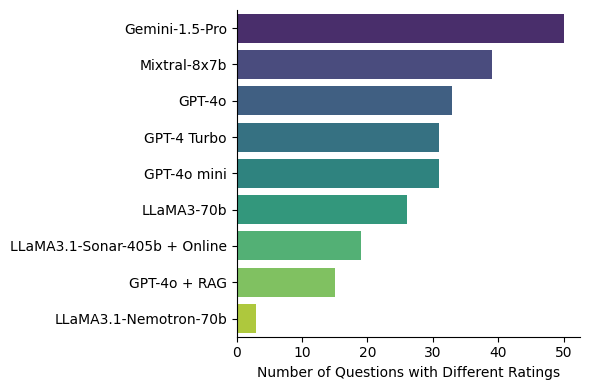

In [21]:
# Pivot the dataframe to have batches as columns for each model and question
pivot_df = data.pivot_table(index=['Question', 'Model'], columns='batch', values='Final Rating', aggfunc=lambda x: x).reset_index()

# Count the number of questions where batches of each model yielded different results
pivot_df['num_unique_ratings'] = pivot_df.iloc[:, 2:].nunique(axis=1)
differences_count = pivot_df[pivot_df['num_unique_ratings'] > 1].groupby('Model').size().reset_index(name='count_different_batches')

# Sort the differences count by frequency
differences_count = differences_count.sort_values(by='count_different_batches', ascending=False)

# Create a bar plot
plt.figure(figsize=(6, 4))


sns.barplot(data=differences_count, x='count_different_batches', y='Model', palette='viridis')
plt.title('')
plt.xlabel('Number of Questions with Different Ratings')
plt.ylabel('')
sns.despine(top=True, right=True)

plt.tight_layout()
plt.savefig('Visualizations\QuestionVariation.png', dpi=300)
plt.savefig('Visualizations\QuestionVariation.eps', dpi=300)
plt.savefig('Visualizations\QuestionVariation.svg', dpi=300)


plt.show()



In [22]:
differences_count

,Model,count_different_batches
4,Gemini-1.5-Pro,50
8,Mixtral-8x7b,39
1,GPT-4o,33
0,GPT-4 Turbo,31
3,GPT-4o mini,31
5,LLaMA3-70b,26
7,LLaMA3.1-Sonar-405b + Online,19
2,GPT-4o + RAG,15
6,LLaMA3.1-Nemotron-70b,3


# Guideline by Year

In [23]:
guidelines_info = {
    "Guideline": [
        "Teratogenesis, Perinatal, and Neurodevelopmental Outcomes After In Utero Exposure to Antiseizure Medication",
        "Pediatric and Adult Brain Death/Death by Neurologic Criteria Consensus Practice Guideline",
        "Stroke Prevention in Symptomatic Large Artery Intracranial Atherosclerosis",
        "Oral and topical treatment of painful diabetic polyneuropathy practice guideline update",
        "Antiseizure medication withdrawal in seizure-free patients practice advisory update",
        "Dopaminergic Therapy for Motor Symptoms in Early Parkinson Disease",
        "Guidelines for the Prevention, Diagnosis, and Treatment of Lyme Disease",
        "Patent foramen ovale and secondary stroke prevention",
        "Treatment for Insomnia and Disrupted Sleep Behavior in Children and Adolescents with Autism Spectrum Disorder",
        "Vaccine-preventable Infections and Immunization in Multiple Sclerosis",
        "Acute Treatment of Migraine in Children and Adolescents",
        "Pharmacologic Treatment for Pediatric Migraine Prevention",
        "Treatment of Tics in People with Tourette Syndrome and Chronic Tic Disorders"
    ],
    "Date Published": [
        "May 15, 2024",
        "December 6, 2023",
        "March 21, 2022",
        "December 27, 2021",
        "December 6, 2021",
        "November 15, 2021",
        "November 30, 2020",
        "April 29, 2020",
        "February 12, 2020",
        "August 28, 2019",
        "August 14, 2019",
        "August 14, 2019",
        "May 6, 2019"
    ],
    "Date Reaffirmed": [
        "N/A",
        "N/A",
        "N/A",
        "N/A",
        "N/A",
        "N/A",
        "October 21, 2023",
        "July 14, 2023",
        "February 25, 2023",
        "October 22, 2022",
        "October 22, 2022",
        "October 22, 2022",
        "April 30, 2022"
    ]
}

guidelines_df = pd.DataFrame(guidelines_info)
guidelines_df["Date Published"] = pd.to_datetime(guidelines_df["Date Published"])

In [24]:
guidelines_list = [
    {
        "Guideline": "Teratogenesis, Perinatal, and Neurodevelopmental Outcomes After In Utero Exposure to Antiseizure Medication",
        "start_q": 1,
        "end_q": 10
    },
    {
        "Guideline": "Pediatric and Adult Brain Death/Death by Neurologic Criteria Consensus Practice Guideline",
        "start_q": 11,
        "end_q": 20
    },
    {
        "Guideline": "Stroke Prevention in Symptomatic Large Artery Intracranial Atherosclerosis",
        "start_q": 21,
        "end_q": 30
    },
    {
        "Guideline": "Oral and topical treatment of painful diabetic polyneuropathy practice guideline update",
        "start_q": 31,
        "end_q": 40
    },
    {
        "Guideline": "Antiseizure medication withdrawal in seizure-free patients practice advisory update",
        "start_q": 41,
        "end_q": 50
    },
    {
        "Guideline": "Dopaminergic Therapy for Motor Symptoms in Early Parkinson Disease",
        "start_q": 51,
        "end_q": 60
    },
    {
        "Guideline": "Guidelines for the Prevention, Diagnosis, and Treatment of Lyme Disease",
        "start_q": 61,
        "end_q": 70
    },
    {
        "Guideline": "Patent foramen ovale and secondary stroke prevention",
        "start_q": 71,
        "end_q": 80
    },
    {
        "Guideline": "Treatment for Insomnia and Disrupted Sleep Behavior in Children and Adolescents with Autism Spectrum Disorder",
        "start_q": 81,
        "end_q": 90
    },
    {
        "Guideline": "Vaccine-preventable Infections and Immunization in Multiple Sclerosis",
        "start_q": 91,
        "end_q": 100
    },
    {
        "Guideline": "Acute Treatment of Migraine in Children and Adolescents",
        "start_q": 101,
        "end_q": 110
    },
    {
        "Guideline": "Pharmacologic Treatment for Pediatric Migraine Prevention",
        "start_q": 111,
        "end_q": 120
    },
    {
        "Guideline": "Treatment of Tics in People with Tourette Syndrome and Chronic Tic Disorders",
        "start_q": 121,
        "end_q": 130
    }
]

# Build the question mapping DataFrame
guideline_question_data = []
for g in guidelines_list:
    for qnum in range(g["start_q"], g["end_q"] + 1):
        guideline_question_data.append({
            "Guideline": g["Guideline"],
            "Question Number": qnum,
        })

gq_df = pd.DataFrame(guideline_question_data)

In [25]:

# Now merge data with gq_df to get the Guideline info
data_merged = pd.merge(
    data,
    gq_df,
    left_on="Question Number",
    right_on="Question Number",
    how="left"
)

# Then merge with guidelines_df to get Date Published, etc.
data_final = pd.merge(
    data_merged,
    guidelines_df,
    on="Guideline",
    how="left"
)


In [26]:
short_name_map = {
    "Teratogenesis, Perinatal, and Neurodevelopmental Outcomes After In Utero Exposure to Antiseizure Medication": "Teratogenesis & ASM",
    "Pediatric and Adult Brain Death/Death by Neurologic Criteria Consensus Practice Guideline": "Brain Death Criteria",
    "Stroke Prevention in Symptomatic Large Artery Intracranial Atherosclerosis": "Stroke Prev (ICAS)",
    "Oral and topical treatment of painful diabetic polyneuropathy practice guideline update": "Diabetic Polyneuropathy",
    "Antiseizure medication withdrawal in seizure-free patients practice advisory update": "ASM Withdrawal",
    "Dopaminergic Therapy for Motor Symptoms in Early Parkinson Disease": "Parkinson Motor Tx",
    "Guidelines for the Prevention, Diagnosis, and Treatment of Lyme Disease": "Lyme Disease",
    "Patent foramen ovale and secondary stroke prevention": "PFO & Stroke",
    "Treatment for Insomnia and Disrupted Sleep Behavior in Children and Adolescents with Autism Spectrum Disorder": "Insomnia in Autism",
    "Vaccine-preventable Infections and Immunization in Multiple Sclerosis": "MS Vaccinations",
    "Acute Treatment of Migraine in Children and Adolescents": "Acute Migraine in Adolescents",
    "Pharmacologic Treatment for Pediatric Migraine Prevention": "Migraine Prev in Adolescents",
    "Treatment of Tics in People with Tourette Syndrome and Chronic Tic Disorders": "Tics & Tourette"
}

# b) Extract year from Date Published and build "ShortNameYear"
data_final["Year"] = data_final["Date Published"].dt.year.astype(str)
data_final["Short Guideline"] = data_final["Guideline"].map(short_name_map)
data_final["ShortNameYear"] =  data_final["Year"] + ": " + data_final["Short Guideline"].astype(str)

# c) Sort guidelines by date to define an ordered category
guidelines_sorted = (
    data_final[["Guideline", "Date Published"]]
    .drop_duplicates()
    .sort_values("Date Published")
)
ordered_guidelines = guidelines_sorted["Guideline"].tolist()

data_final["Guideline"] = pd.Categorical(
    data_final["Guideline"],
    categories=ordered_guidelines,
    ordered=True
)

# d) For plotting, we also want an ordered ShortNameYear in the same order
#    We'll create a small helper mapping from Guideline -> ShortNameYear
_guide_to_short = (
    data_final[["Guideline", "ShortNameYear"]]
    .drop_duplicates()
    .set_index("Guideline")["ShortNameYear"]
    .to_dict()
)
# Re-map in that sorted order
data_final["ShortNameYear"] = data_final["Guideline"].map(_guide_to_short)
ordered_shortnames = [ _guide_to_short[g] for g in ordered_guidelines ]

In [27]:
data_final["IsCorrect"] = data_final["Final Rating"].eq("Correct")
pct_correct = (
    data_final
    .groupby(["ShortNameYear", "Model"], as_index=False)["IsCorrect"]
    .mean()
)
pct_correct["Correct (%)"] = pct_correct["IsCorrect"] * 100

C:\Users\larsm\AppData\Local\Temp\ipykernel_5576\4063737434.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data_final


C:\Users\larsm\AppData\Local\Temp\ipykernel_5576\1609851832.py:8: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  ax = sns.pointplot(
C:\Users\larsm\AppData\Local\Temp\ipykernel_5576\1609851832.py:8: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0}` instead.

  ax = sns.pointplot(
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


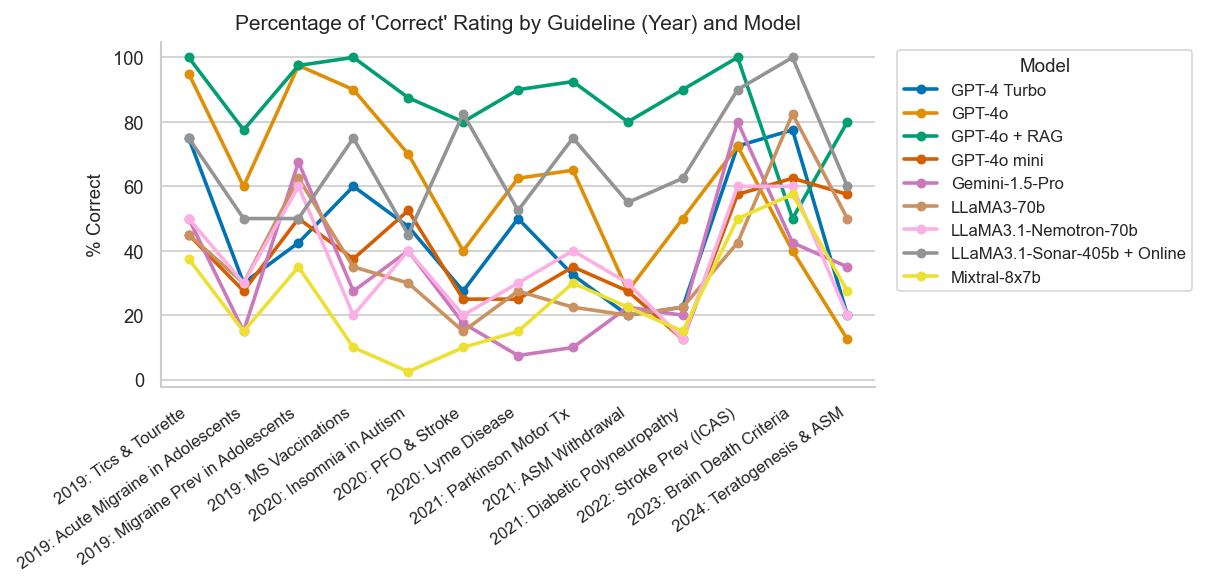

In [28]:


# Example: smaller context, colorblind palette
sns.set_theme(style="whitegrid", context="paper", palette="colorblind")

# For a leaner figure, reduce figure size
plt.figure(figsize=(8, 4), dpi=150)

# Create a point plot with lighter lines, smaller markers
ax = sns.pointplot(
    data=pct_correct,
    x="ShortNameYear",       # or your x-axis column
    y="Correct (%)",
    hue="Model",
    linestyles="-",
    markers="o",
    dodge=0,
    scale=0.8,               # controls relative marker size
    errwidth=0,              # hide error bars or set them smaller
)

# Make x‐axis labels smaller & rotated
plt.xticks(rotation=35, ha="right", fontsize=8)

# Adjust axis labels & title font sizes
plt.xlabel("")  # or shorten label text
plt.ylabel("% Correct", fontsize=9)
plt.title("Percentage of 'Correct' Rating by Guideline (Year) and Model", fontsize=10)

# Move legend outside; use smaller text
plt.legend(
    title="Model", 
    bbox_to_anchor=(1.02, 1), 
    loc="upper left",
    fontsize=8,       # smaller legend font
    title_fontsize=9  # smaller title
)

# Optionally remove spines or lighten them
sns.despine(left=False, bottom=False)

plt.tight_layout()

plt.savefig('Visualizations\Correct_Over_Time.png', dpi=300)
plt.savefig('Visualizations\Correct_Over_Time.eps', dpi=300)
plt.savefig('Visualizations\Correct_Over_Time.svg', dpi=300)
plt.show()


In [29]:
data_final["IsCorrect"] = data_final["Source"].str.contains("Hallu")
pct_hallucination = (
    data_final
    .groupby(["ShortNameYear", "Model"], as_index=False)["IsCorrect"]
    .mean()
)
pct_hallucination["Correct (%)"] = pct_hallucination["IsCorrect"] * 100

C:\Users\larsm\AppData\Local\Temp\ipykernel_5576\4111097798.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data_final


C:\Users\larsm\AppData\Local\Temp\ipykernel_5576\78974491.py:8: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  ax = sns.pointplot(
C:\Users\larsm\AppData\Local\Temp\ipykernel_5576\78974491.py:8: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0}` instead.

  ax = sns.pointplot(
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


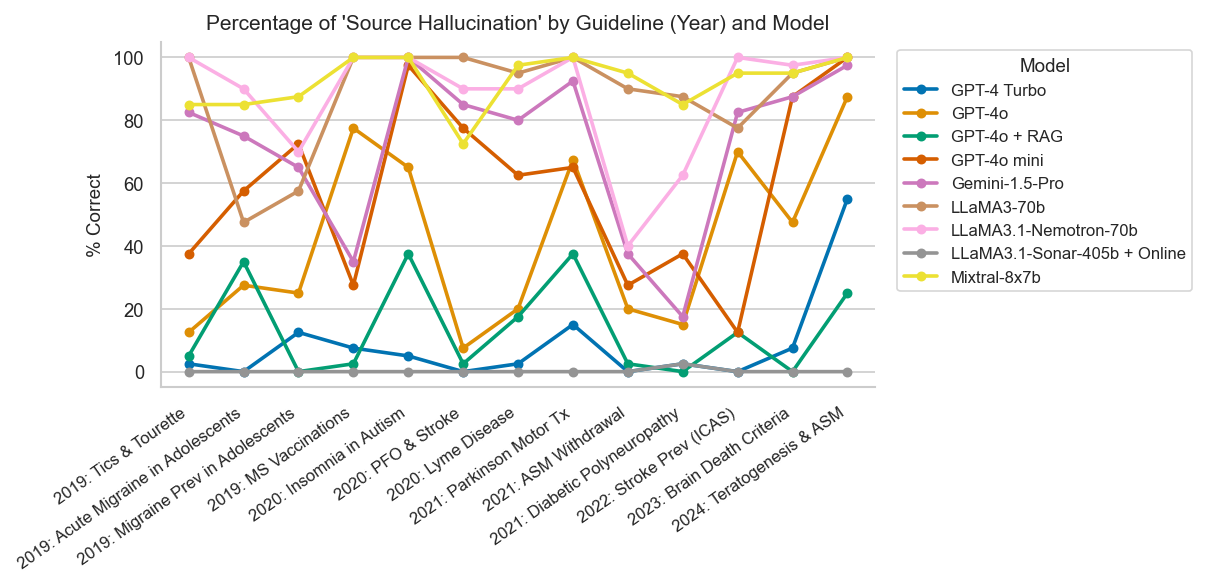

In [30]:


# Example: smaller context, colorblind palette
sns.set_theme(style="whitegrid", context="paper", palette="colorblind")

# For a leaner figure, reduce figure size
plt.figure(figsize=(8, 4), dpi=150)

# Create a point plot with lighter lines, smaller markers
ax = sns.pointplot(
    data=pct_hallucination,
    x="ShortNameYear",       # or your x-axis column
    y="Correct (%)",
    hue="Model",
    linestyles="-",
    markers="o",
    dodge=0,
    scale=0.8,               # controls relative marker size
    errwidth=0,              # hide error bars or set them smaller
)

# Make x‐axis labels smaller & rotated
plt.xticks(rotation=35, ha="right", fontsize=8)

# Adjust axis labels & title font sizes
plt.xlabel("")  # or shorten label text
plt.ylabel("% Correct", fontsize=9)
plt.title("Percentage of 'Source Hallucination' by Guideline (Year) and Model", fontsize=10)

# Move legend outside; use smaller text
plt.legend(
    title="Model", 
    bbox_to_anchor=(1.02, 1), 
    loc="upper left",
    fontsize=8,       # smaller legend font
    title_fontsize=9  # smaller title
)

# Optionally remove spines or lighten them
sns.despine(left=False, bottom=False)

plt.tight_layout()
plt.savefig('Visualizations\Hallucination_Over_Time.png', dpi=300)
plt.savefig('Visualizations\Hallucination_Over_Time.eps', dpi=300)
plt.savefig('Visualizations\Hallucination_Over_Time.svg', dpi=300)
plt.show()


# Calculate Cosine Similarity and BLEU

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction


# Extract relevant columns
answers_data = data[['Sample Answer According to Guideline', 'De Facto Answer', 'Model']]

# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Compute TF-IDF matrices for Sample Answer and De Facto Answer
tfidf_matrix = tfidf_vectorizer.fit_transform(
    answers_data['Sample Answer According to Guideline'].fillna('') +
    answers_data['De Facto Answer'].fillna('')
)

# Split matrices for cosine similarity calculation
sample_tfidf = tfidf_vectorizer.transform(answers_data['Sample Answer According to Guideline'].fillna(''))
de_facto_tfidf = tfidf_vectorizer.transform(answers_data['De Facto Answer'].fillna(''))

# Compute cosine similarity
answers_data['Cosine Similarity'] = cosine_similarity(sample_tfidf, de_facto_tfidf).diagonal()

# Compute BLEU scores
smoothing_function = SmoothingFunction().method1
answers_data['BLEU Score'] = answers_data.apply(
    lambda row: sentence_bleu(
        [row['Sample Answer According to Guideline'].split()],
        row['De Facto Answer'].split(),
        smoothing_function=smoothing_function
    ) if row['De Facto Answer'] and row['Sample Answer According to Guideline'] else 0,
    axis=1
)

# Aggregate by Model with median and IQR
def iqr(values):
    q1, q3 = np.percentile(values, [25, 75])
    return q3 - q1

aggregated_metrics = answers_data.groupby('Model').agg({
    'Cosine Similarity': [np.median, iqr],
    'BLEU Score': [np.median, iqr]
}).reset_index()

# Rename columns for clarity
aggregated_metrics.columns = ['Model', 'Cosine Similarity (Median)', 'Cosine Similarity (IQR)', 
                               'BLEU Score (Median)', 'BLEU Score (IQR)']

# Sort by Cosine Similarity (Median)
aggregated_metrics.sort_values("Cosine Similarity (Median)", inplace=True, ascending=False)

# Create a Word document and table
document = docx.Document()
document.add_heading('Performance Metrics by Model (Median and IQR)', level=1)

# Create a table with column headers
table = document.add_table(rows=1, cols=5)
table.style = 'Light Grid Accent 1'
header_cells = table.rows[0].cells
header_cells[0].text = 'Model'
header_cells[1].text = 'Cosine Similarity (Median)'
header_cells[2].text = 'Cosine Similarity (IQR)'
header_cells[3].text = 'BLEU Score (Median)'
header_cells[4].text = 'BLEU Score (IQR)'

# Fill the table rows with results
for _, row in aggregated_metrics.iterrows():
    row_cells = table.add_row().cells
    row_cells[0].text = row['Model']
    row_cells[1].text = f"{row['Cosine Similarity (Median)']:.4f}"
    row_cells[2].text = f"{row['Cosine Similarity (IQR)']:.4f}"
    row_cells[3].text = f"{row['BLEU Score (Median)']:.4f}"
    row_cells[4].text = f"{row['BLEU Score (IQR)']:.4f}"

# Ensure the directory exists
import os
os.makedirs('Results', exist_ok=True)

# Save to file
document.save('Results/performance_metrics_by_model_median_iqr.docx')
print("DOCX file 'performance_metrics_by_model_median_iqr.docx' created successfully.")


C:\Users\larsm\AppData\Local\Temp\ipykernel_5576\915911407.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  answers_data['Cosine Similarity'] = cosine_similarity(sample_tfidf, de_facto_tfidf).diagonal()


DOCX file 'performance_metrics_by_model_median_iqr.docx' created successfully.


C:\Users\larsm\AppData\Local\Temp\ipykernel_5576\915911407.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  answers_data['BLEU Score'] = answers_data.apply(
C:\Users\larsm\AppData\Local\Temp\ipykernel_5576\915911407.py:41: FutureWarning: The provided callable <function median at 0x000002B47EF393F0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  aggregated_metrics = answers_data.groupby('Model').agg({
C:\Users\larsm\AppData\Local\Temp\ipykernel_5576\915911407.py:41: FutureWarning: The provided callable <function median at 0x000002B47EF393F0> is currently using SeriesGroupBy.median. In a future version of pandas, th